#### Github:
https://github.com/hibbakamas/ML-fundamentals-2025.git

# Hibba Kamas Machine Learning Assignment 2

In [1901]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from boruta import BorutaPy

# Task 1: Exploratory Data Analysis (EDA)

In [1902]:
# Load dataset
df = pd.read_csv("hour.csv")

# Show first few rows
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Checking Dataset Structure

Before starting to create the model, it's important to understand the structure and contents of the dataset. I began by checking the shape of the dataset and listing the column names. This gives a quick overview of how many observations we have (17,379 rows) and how many features (17 columns), helping us understand the dataset better before continuing.

In [1903]:
# basic info about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns)

Dataset Shape: (17379, 17)

Column Names:
 Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')


#### Identifying Missing Values

Missing data can affect the model's accuracy, so it is very important to assess which features have missing values. Luckily in this case, there are no missing values

In [1904]:
# Check number of missing values per column (if any)
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Summary Statistics Observations

After gaining a general overview of the dataset, .describe() and .info() are used to view summary statistics about the dataset. Some key observations include:

- All 17 columns contain 17,379 non-null entries, which confirms there are no missing values.
- Most features are numerical, with only one object column ("dteday").
- The target variable "cnt" (total bike rentals) ranges from 1 to 977, with a mean around 189. This wide range suggests a right-skewed distribution, which may affect linear modeling.
- "temp", "atemp", "hum", and "windspeed" are normalized between 0 and 1.
- Binary features like "holiday" and "workingday" have values of 0 or 1.
- Columns like "season", "hr", "weekday", and "weathersit" are encoded as categorical integers, which we should keep in mind when making the different models.
- The "instant" column is a unique identifier and does not carry predictive value, so it will be dropped.
- The "dteday" column represents the date as a string and does not add predictive value either, so it will also be dropped.

In [1905]:
# Check the structure and types of the dataset
df.info()
# Get basic statistics for numerical columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Distributions and outliers

After observing that our target variable could possibly be right-skewed, I decided to investigate further by using a histogram. The histogram confirmed that cnt is indeed right skewed, with most rental counts being quite low and then a sharp drop as the count increases.

Skewness is very important to keep in mind, especially for linear regression, which assumes the target and residuals are normally distributed. To address this, we could apply a log transformation to the target variable, to better meet the assumption of normality and linearity. 

Although random forests and gradient boosting are more robust to skewed data since they do not assume any underlying distribution, understanding the distribution of the target variable may help with tuning and identifying outliers and imbalances.

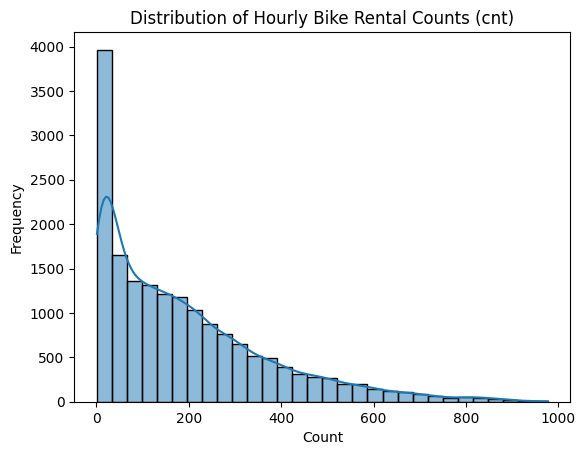

In [1906]:
# Histogram of the target variable
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title("Distribution of Hourly Bike Rental Counts (cnt)")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()


Since extreme values in numerical features can mess up the model's predictions, I decided to do a formal outlier check the target variable. Outliers can affect model's in different ways:
- In linear regression, outliers can heavily influence the fitted line which may skew results. Outlier handling methods or transformations may be necessary.
- Gradient boosting and random forests are more robust to outliers due to their non-linear nature. Extreme values tend to be in separate branches, minimizing their impact.

In the boxplot, we can see a large number of outliers on the higher end, more specifically beyond 600. These high values are not necessarily errors, they might just be busier times, such as rush hour. Hence, it is not for sure that they will be removed, but I can now make more informed decisions about whether to:
- Apply a log transformation in linear regression
- Leave them untouched for tree based models
- Investigate them further depending on model performance

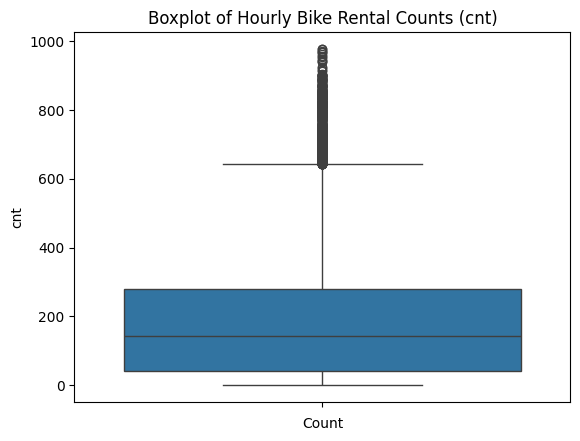

In [1907]:
# Boxplot to check for outliers
sns.boxplot(y=df['cnt'])
plt.title("Boxplot of Hourly Bike Rental Counts (cnt)")
plt.xlabel("Count")
plt.show()


To better understand the behavior of the numerical input features, I visualized their distributions and boxplots. This helped identify skewness, outliers, and patterns that might impact the model.

Instead of automatically selecting numerical features using select_dtypes(), I manually selected them based on dataset knowledge. I preferred this method because sometimes, some columns are classified as numerical due to their integer values, but are actually categorical (season, yr, mnth, etc).

Some key observations include:
- Distributions:
    - temp, atemp, and hum are rougly symmetric and are fairly well distributed.
    - windspeed, casual, and registers are right skewed, with many low values and few high values. These features might need transformation, depending on the model.
    - temp and atemp look very similar, implying one might be redundant. A correlation check should be done.
    - casual and registered also seem very similar to each other, as well as to cnt. Based on dataset knowledge, I figure that cnt is the sum of casual and registered. It is important to verify this later, as if this is true it will lead to data leakage.
- Outliers:
    - Boxplots showed outliers in windspeed, casual, and registered.
    - These values are not necessarily errors, and may represent real-world scenarios such as a windy day
    - In linear regression, these outliers may mess up predictions and might require transformation, however in tree based models outliers are isolated and have less impact.

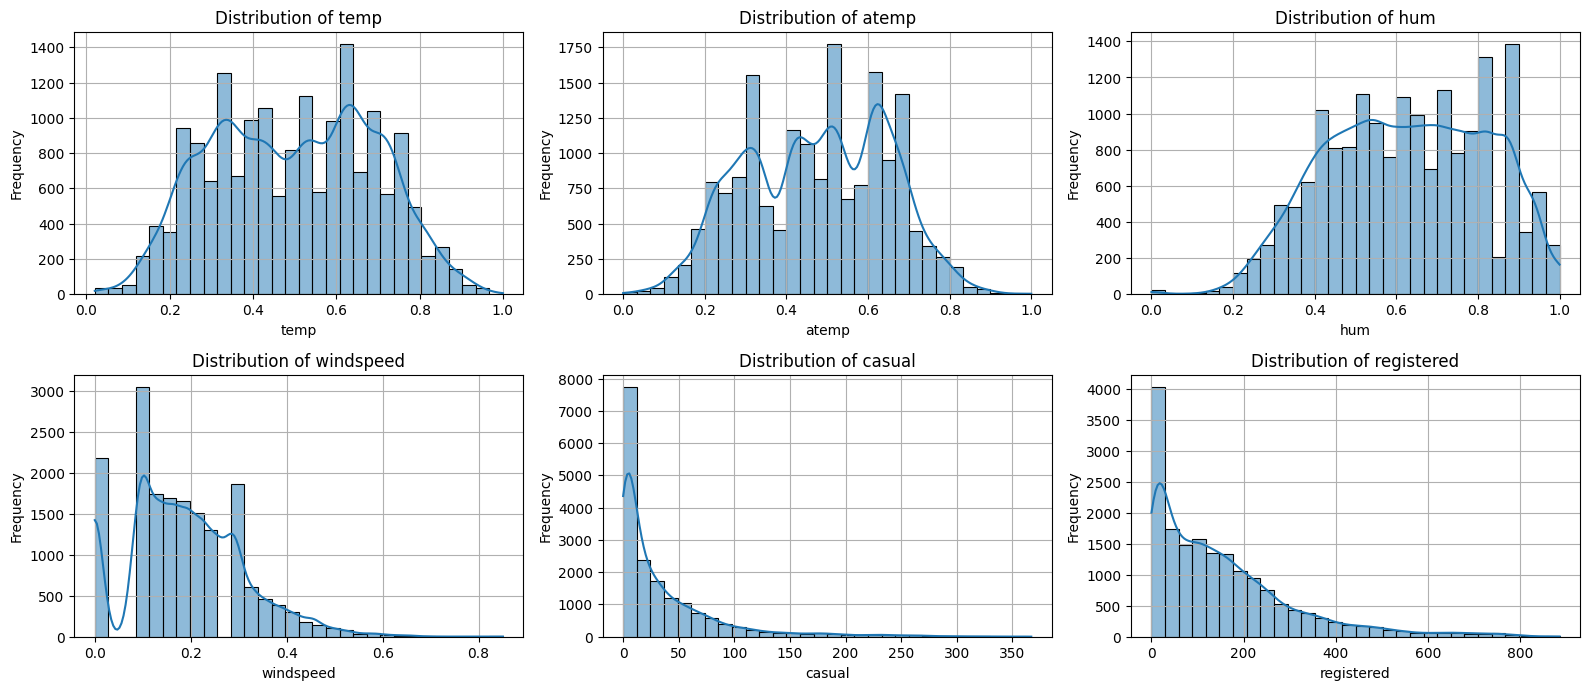

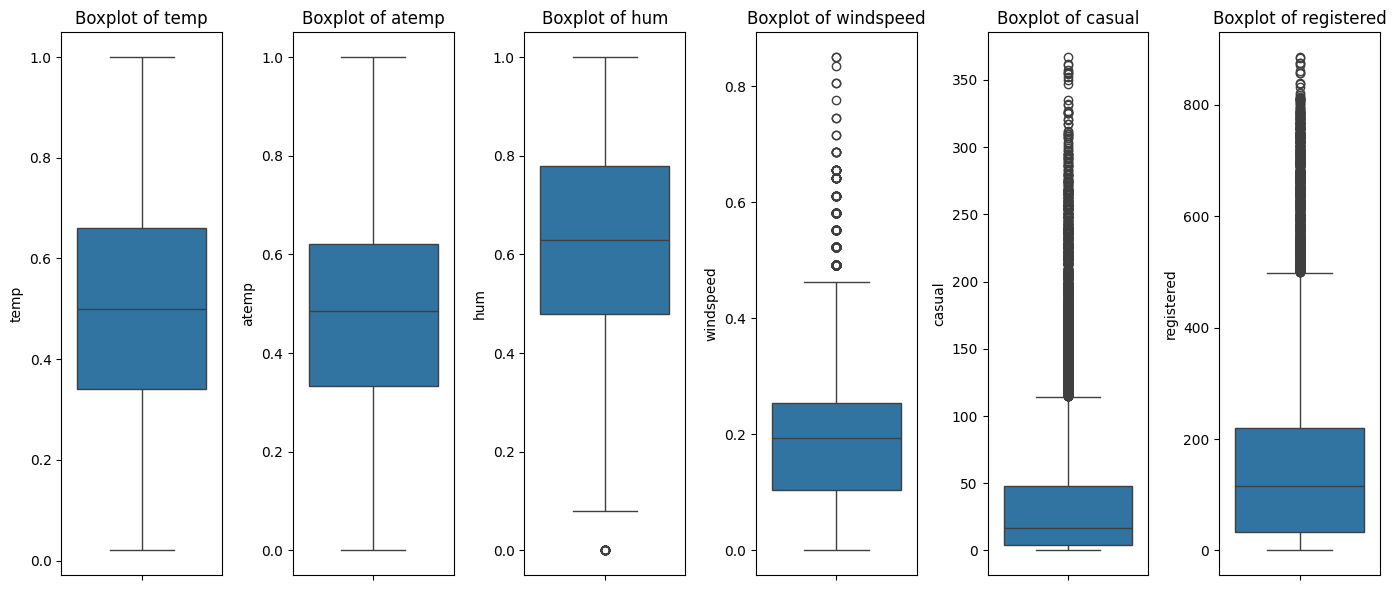

In [1908]:
numerical_features = ["temp", "atemp", "hum", "windspeed", "casual", "registered"]

# distributions
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.grid(True)
plt.tight_layout()
plt.show()

# boxplots
plt.figure(figsize=(14, 6))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 6, i)
    sns.boxplot(y=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

Since earlier I thought that cnt could be the sum of casual and registered, I decided to confirm this with a scatter plot of casual + registered against cnt. This result showed a perfect linear relationship. To be extra thorough, I also ran a check to see if there were any mismatches between casual + registered and cnt. The mismatch count was 0, finally confirming what I originally thought.

This is a very important find, as including both features when predicting cnt would lead to data leakage, since they directly determine the target. These two columns should be dropped before modeling to ensure the model does not 'cheat'.

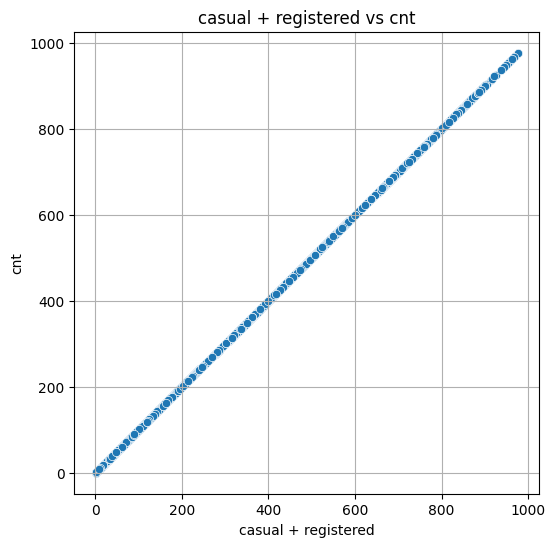

Number of mismatches: 0


In [1909]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df['casual'] + df['registered'], y=df['cnt'])
plt.title("casual + registered vs cnt")
plt.xlabel("casual + registered")
plt.ylabel("cnt")
plt.grid(True)
plt.show()

# Check if any rows break the rule: casual + registered == cnt
mismatch_count = (df['casual'] + df['registered'] != df['cnt']).sum()
print("Number of mismatches:", mismatch_count)

### Influence of temporal features
For temporal features like hr, weekday, and mnth, Line plots were used to visualize the average rental trends. Line plots work very well for ordered, time based variables because they highlight changes/patterns across a continuous timeline very clearly.


Hour:

First, I thought to explore the influence of time on bike usage. I began by checking the average number of rentals for each hour of the day, since different hours of the day (eg, rush hour) may behave differently.

From the line plot, I observed:
- From the hours of 12:00am to 6:00am, usage is at it's lowest. This makes sense considering most people are likely asleep and not commuting at this time.
- There is a sharp increase from 6:00am to 8:00am, which corresponds to common morning commute times. This suggests many people rely on bikes to get to work or school.
- From 9:00am to 4:00pm rentals decrease and remain relatively steady, but between 4:00pm and 7:00pm rentals go back up, corresponding to the time people commute home from work or school.

This hourly pattern is clearly non linear, meaning:
- Tree based models (gradient boosting, random forests) are well suited since they are flexible to non linearity.
- Linear models may struggle unless we apply transformations.

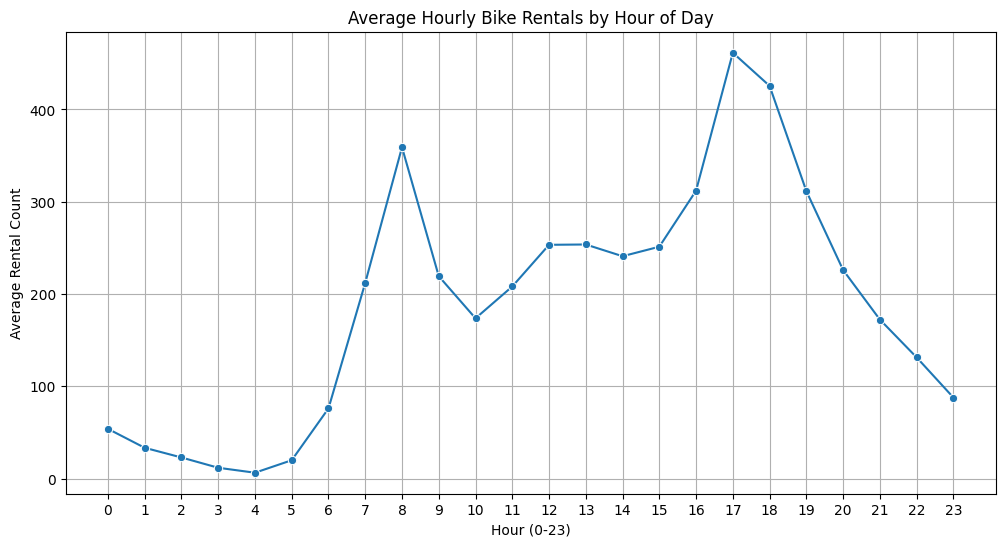

In [1910]:
# Average bike rentals by hour of the day
avg_by_hour = df.groupby("hr")["cnt"].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_by_hour.index, y=avg_by_hour.values, marker="o")
plt.title("Average Hourly Bike Rentals by Hour of Day")
plt.xlabel("Hour (0-23)")
plt.ylabel("Average Rental Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Weekday:

Next, I checked how different days of the week affect bike rentals, gaining a more general influence of time's influence. I plotted the average rental count per day using a line plot, since weekdays follow a natural timeline.

From the plot, I observed:
- Rentals are lowest on Sunday, then begin to increase during the week. This might suggest people stay home more often on Sundays.
- The highest usage is on Thursday and Friday, which may be due to a combination of work, errands, and social plans.
- Rentals drop slightly on Saturday, probably because people are not commuting to work/school.

Although there aren't huge differences, the pattern suggests that weekday does indeed have some influence on rentals. Its ordered nature may benefit tree-based models, however linear models might require  encoding to properly interpret it. In this case, one hot encoding may be more appropriate than ordinal encoding even though weekday is ordered, because its relationship with the target is not linear.

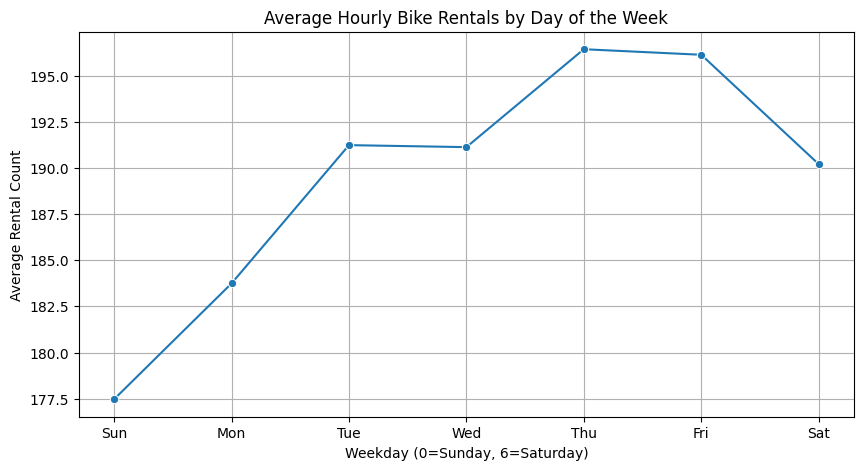

In [1911]:
# Average rentals by weekday (0=Sunday, 6=Saturday)
avg_by_weekday = df.groupby("weekday")["cnt"].mean()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_weekday.index, y=avg_by_weekday.values, marker="o")
plt.title("Average Hourly Bike Rentals by Day of the Week")
plt.xlabel("Weekday (0=Sunday, 6=Saturday)")
plt.ylabel("Average Rental Count")
plt.xticks(range(0, 7), labels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
plt.grid(True)
plt.show()


Month:

I then visualized the influence of the month of bike rentals, gaining an even more general overview of the influence of time.

From the plot, I observed:
- Rentals continuously increase from January to June (peak), and stay high during the warmer months (June to September).
- After September, rentals begin to drop, with the lowest rentals in the coldest months (December to Febuary).
- This pattern seems to reflect seasonal weather effects, suggesting that people prefer to ride bikes in warmer, drier months,

Again, this trend is clearly non-linear, hence although tree based models do not require transformations, linear models would.

Here, the relationship between month and cnt seems to follow a clear downward u shape. Creating a variable mnth^2 might help linear regression models capture this relationship better and won't have negative effects on random forest or gradient boosting models.

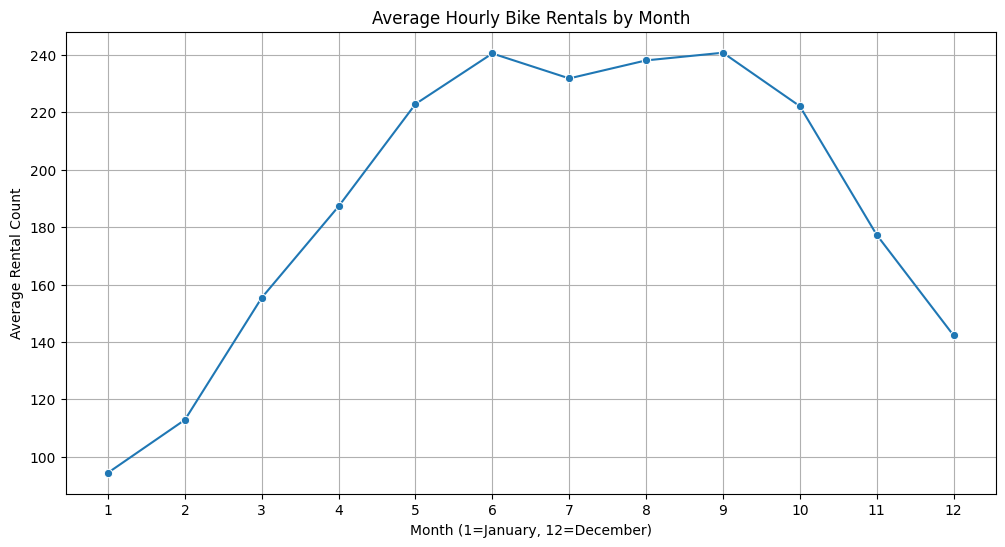

In [1912]:
# Average rentals by month
avg_by_month = df.groupby("mnth")["cnt"].mean()

# Line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_by_month.index, y=avg_by_month.values, marker="o")
plt.title("Average Hourly Bike Rentals by Month")
plt.xlabel("Month (1=January, 12=December)")
plt.ylabel("Average Rental Count")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

Season:

Finally, since the hourly bike rentals by month seemed to vary depending on the season, I visualized the average rental count using a bar plot.

From the plot, I observed:
- Rentals are lowest in Winter, implying people do not like to ride bikes in the cold.
- Rentals increase in Spring and Summer, with Summer having the highest average. This suggests warm weather encourages biking.
- In fall, rentals slightly drop, but are still relatively high.

These are the same interpretations inferred from analyzing the months of the year, implying the rental count changes in the months might be due to seasonal changes.

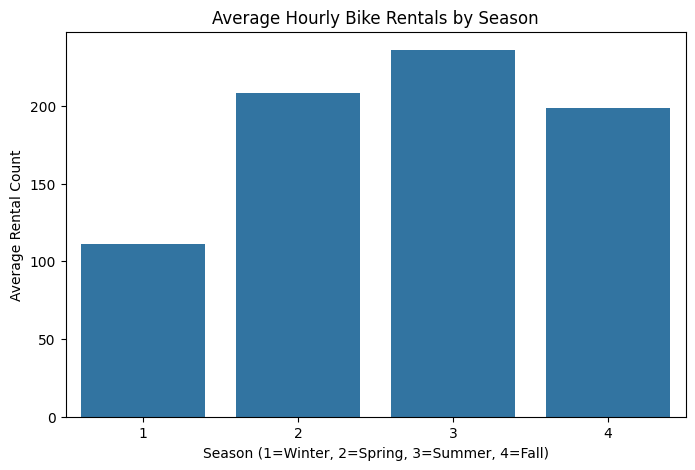

In [1913]:
avg_by_season = df.groupby("season")["cnt"].mean()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_season.index, y=avg_by_season.values)
plt.title("Average Hourly Bike Rentals by Season")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Average Rental Count")
plt.show()

### Influence of binary features
Since these features only take two values (0 and 1), bar plots are the most intuitive and effective way to compare their impact on the target variable.

Holiday:

To check whether holidays influence bike rentals, I plotted the average rental count grouped by holiday.

From the plot, I observed:
- Rentals are higher on non holidays compared to holidays.
- The reason for this might be because people normally commute to work/school on non holidays using bikes.

Although the difference is not huge, this shows holiday does have some influence on the target variable and implies it should be kept.

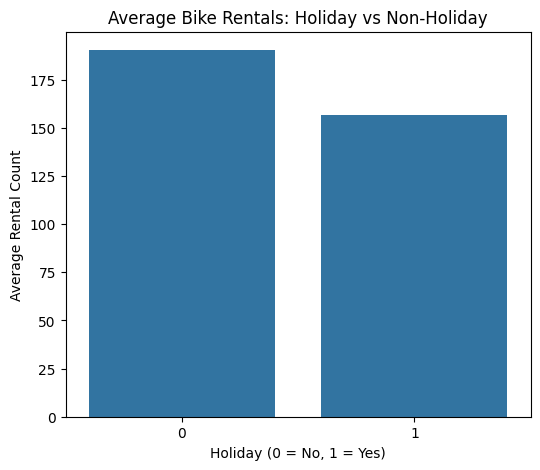

In [1914]:
# Average rentals grouped by holiday
avg_by_holiday = df.groupby("holiday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=avg_by_holiday.index, y=avg_by_holiday.values)
plt.title("Average Bike Rentals: Holiday vs Non-Holiday")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

Working day:

To see how working days might affect bike rentals, I used a bar plot to compare average rental counts between working and non working days.

From the plot, I observed:
- Rentals are just slightly higher on working days.
- This makes sense and aligns with everything said previously, people rely on bikes as part of their commute to work/school.

The difference is only small, but still shows some relationship with the target variable.

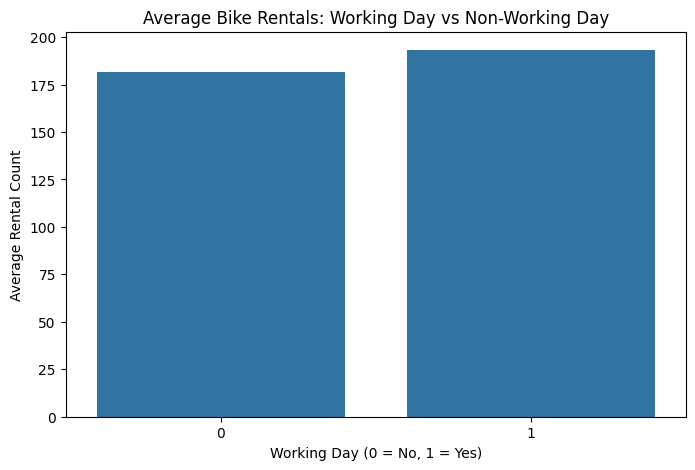

In [1915]:
# Average rentals by working day
avg_by_workingday = df.groupby("workingday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_workingday.index, y=avg_by_workingday.values)
plt.title("Average Bike Rentals: Working Day vs Non-Working Day")
plt.xlabel("Working Day (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

### Influence of weather related features

Line plots were used for continuous features (temp, atemp, hum, and windspeed) and bar plots for categorical ones (weathersit).

Temp:

I first felt it was important to understand how temperature influences bike usage, since it seemed to have a large impact in earlier analysis. So, I plotted the average rental count for each unique normalized temperature value using a line plot.

From the plot, I observed:
- Rentals tend to increase with temperate, which confirms our earlier hypothesis that people prefer renting bikes in warmer weather.
- The trend becomes less consistent at higher temperatures, possibly due to fewer data points at those extremes.

This relationship is more or less linear, and can be handled well with linear models and tree based models.

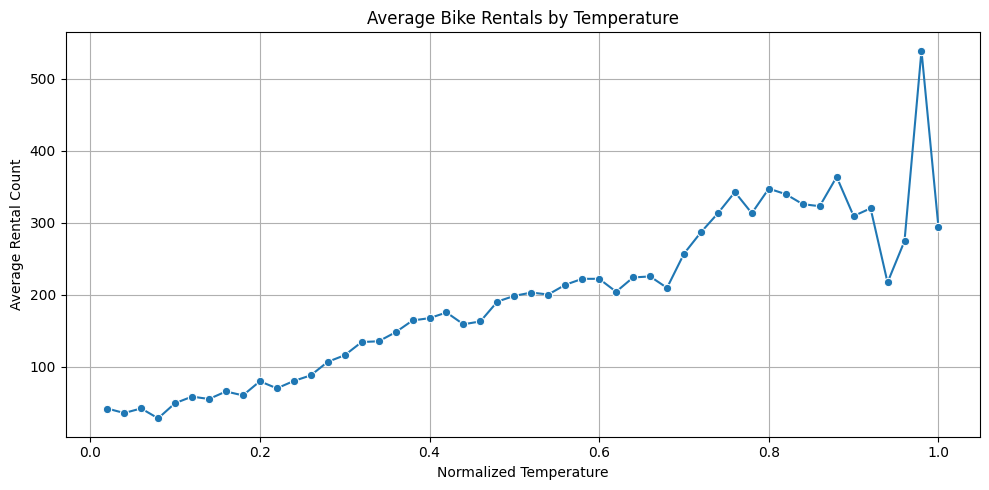

In [1916]:
# Average rentals by temperature
avg_temp = df.groupby("temp")["cnt"].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="temp", y="cnt", data=avg_temp, marker="o")
plt.title("Average Bike Rentals by Temperature")
plt.xlabel("Normalized Temperature")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Atemp:

I also checked how the "feels like" temperature influences bike usage, since this might have more of an impact on people if it is the temperature they actually feel.

From the plot, I observed:
- Rentals increase as "feels like" temperature increases.
- The pattern is very similar to temp, implying some correlation that should be checked.

Again, the pattern is more or less linear, with the behavior closely mirroring temp. This supports the earlier assumption that one of these features might be redundant.

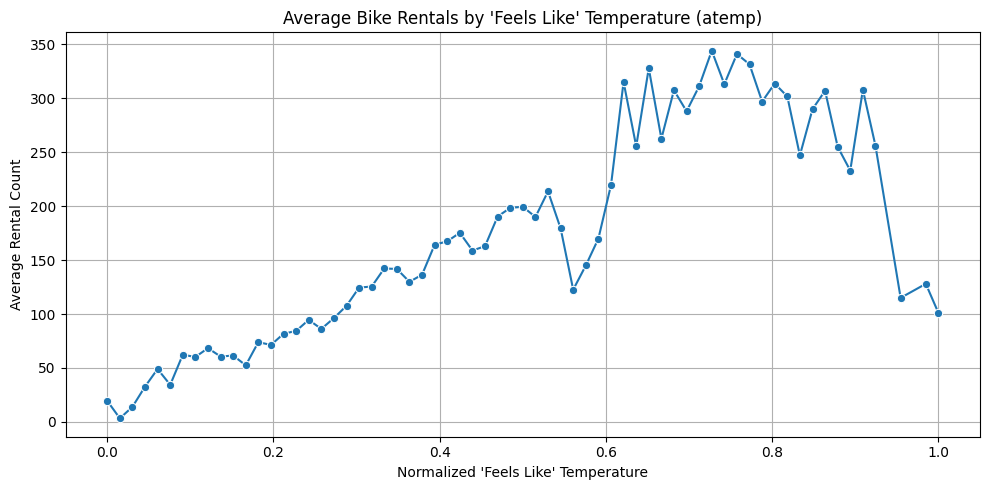

In [1917]:
# Average rentals by atemp
avg_atemp = df.groupby("atemp")["cnt"].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x="atemp", y="cnt", data=avg_atemp, marker="o")
plt.title("Average Bike Rentals by 'Feels Like' Temperature (atemp)")
plt.xlabel("Normalized 'Feels Like' Temperature")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.tight_layout()
plt.show()

Humidity:

Next, I analyzed how humidity might affect bike rentals rates, as humid weather tends to be less enjoyable. I used a line plot to capture this relationship.

From the plot, I observed:
- Rentals increase as humidity rises from 0 to 0.2, suggesting people do not prefer overly dry weather to ride their bikes.
- After this, rental counts decline as humidity increases, confirming my earlier assumption.

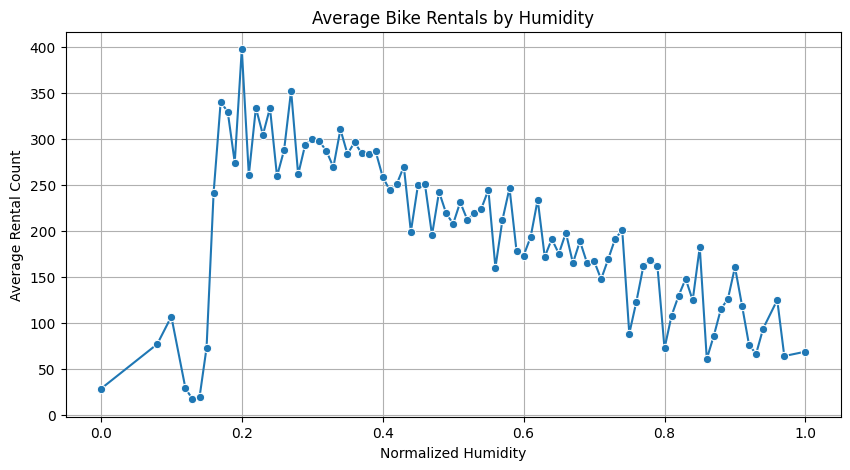

In [1918]:
# Average rentals by humidity
avg_by_hum = df.groupby("hum")["cnt"].mean()

# Line plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_hum.index, y=avg_by_hum.values, marker="o")
plt.title("Average Bike Rentals by Humidity")
plt.xlabel("Normalized Humidity")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.show()

Windspeed:

I then explored how windspeed would affect bike rentals using a lineplot, as windier weather is not ideal for riding a bike.

From the plot, I observed:
- Rental counts are pretty stable across low to moderate windspeeds.
- At higher windspeeds (beyond 0.6) rental counts begin to drop, though it is difficult to tell probably due to fewer data points.

The overall influence of windspeed is very mild, but it may have a slight negative effect on rentals at higher windspeeds.

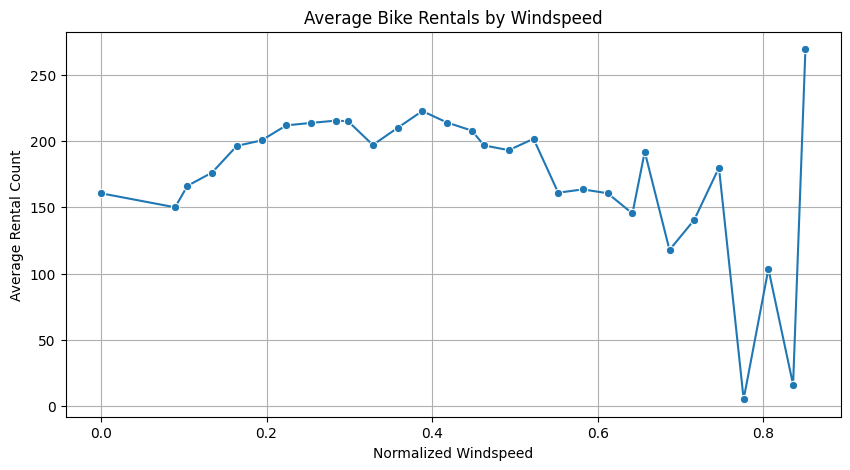

In [1919]:
# Calculate average rental count by windspeed
avg_by_windspeed = df.groupby("windspeed")["cnt"].mean()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(x=avg_by_windspeed.index, y=avg_by_windspeed.values, marker="o")
plt.title("Average Bike Rentals by Windspeed")
plt.xlabel("Normalized Windspeed")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.show()

Weathersit:

I finally explored how different weather conditions may influence bike rentals, excluding category 4 due to its extremely low frequency which will just add noise.

From the plot, I observed:
- Rentals are highest on clear or partly cloudy days, which makes sense as the weather is ideal for biking.
- Rentals decrease on misty or cloudy days, possibly because of reduced visibility.
- Rentals experience a sharp drop when it rains or snows lightly, suggesting that bad weather discourages biking.

This analysis showed that weathersit clearly influences rental behavior, and should be kept as a feature in the model.

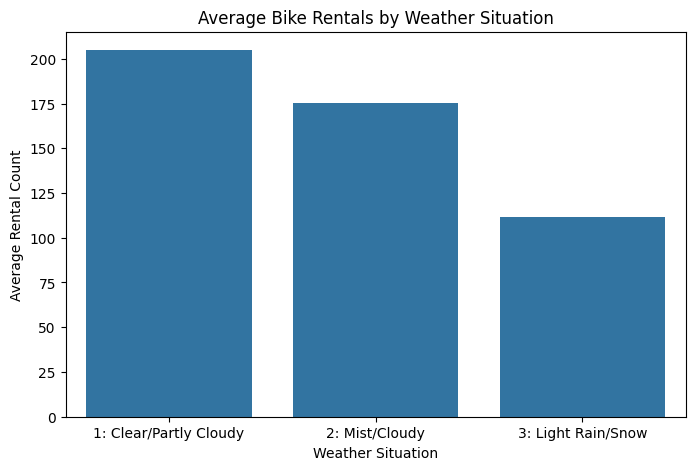

In [1920]:
# Filter out rows where weathersit is 4
df_filtered = df[df["weathersit"] != 4]

# Define custom labels for valid categories
weather_labels = [
    "1: Clear/Partly Cloudy",
    "2: Mist/Cloudy",
    "3: Light Rain/Snow"
]

# Group by weather situation and calculate average rentals
avg_by_weather = df_filtered.groupby("weathersit")["cnt"].mean()

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_by_weather.index, y=avg_by_weather.values)
plt.title("Average Bike Rentals by Weather Situation")
plt.xlabel("Weather Situation")
plt.ylabel("Average Rental Count")
plt.xticks(ticks=[0, 1, 2], labels=weather_labels)
plt.show()

In [1921]:
print("Number of entries where weathersit = 4:", (df["weathersit"] == 4).sum())

Number of entries where weathersit = 4: 3


### Possible interaction terms

Temperature x humidity:

I tested this interaction because logically, humidity might affect how temperature affects bike rentals. I would assume for example that the combination of high heat and high humidity would make people less likely to ride bikes in comparison to high heat with low humidity.

To test this, I used a grouped lineplot to check for the interaction visually. Grouped by different levels of humidity, the slopes of temperature vs count seemed to differ depending on the humidity level. If this is true, this would mean that temp and hum do indeed have an interaction.

I decided to properly check for the slopes, since the graph was not 100% clear. The slopes were calculated as 447.72 for low humidity, and only 196.54 for high humidity. This large gap in slopes confirms an interaction effect that should be tested, feature 'temp_hum' may be created.

<Axes: xlabel='temp', ylabel='cnt'>

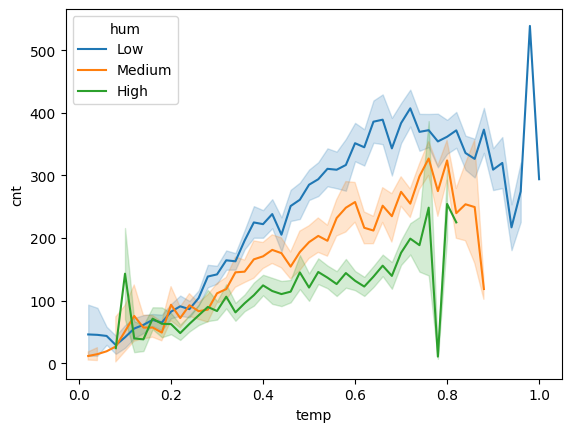

In [1922]:
sns.lineplot(
    data=df,
    x='temp',
    y='cnt',
    hue=pd.qcut(df['hum'], q=3, labels=['Low', 'Medium', 'High'])
)


In [1923]:
# Calculate slope for each humidity group without creating new columns
slopes = {}
hum_groups = pd.qcut(df['hum'], q=3, labels=['Low', 'Medium', 'High'])

for group in ['Low', 'Medium', 'High']:
    # Filter the data without creating a new column
    mask = hum_groups == group
    group_temp = df.loc[mask, 'temp']
    group_cnt = df.loc[mask, 'cnt']
    
    # Calculate slope for this group
    slope, intercept = np.polyfit(group_temp, group_cnt, 1)
    slopes[group] = slope

print("Slopes (temp vs cnt) for each humidity group:")
for group, slope in slopes.items():
    print(f"{group} humidity: {slope:.4f}")

Slopes (temp vs cnt) for each humidity group:
Low humidity: 447.7213
Medium humidity: 379.6576
High humidity: 196.5361


The next interaction I tested was whether the effect of the hour of the day on bike rentals were different on working days vs non working days. This would make sense, as rush hour for example is much more likely on working days.

I used a grouped lineplot of rental count by hour, split by whether it was a working day or not. The plot showed two completely different patterns. On working days, there was a double peak (8am and 5pm), aligning with commuting hours. On on working days, the pattern is much smoother with one rise at around midday, and no peaks.

These major differences show that the relationship between hour and rentals differs a lot across working/non-working days. This confirms a strong interaction. A new feature 'hour_workingday' may be created.

<Axes: xlabel='hr', ylabel='cnt'>

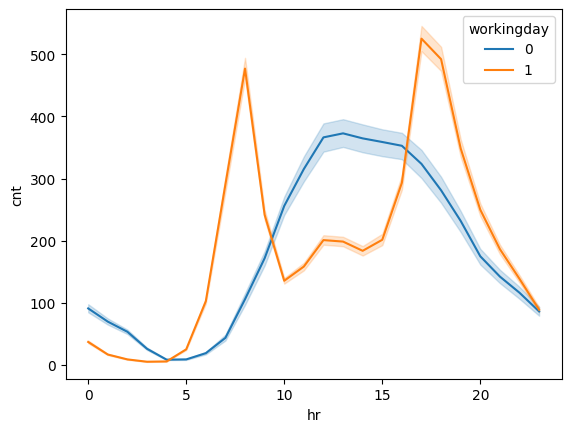

In [1924]:
sns.lineplot(data=df, x='hr', y='cnt', hue='workingday')

This interaction was checked since I thought the effect of the time of the day might change depending on the temperature (for example, people may ride bikes less midday if it is very hot).

To test this, I created a grouped lineplot of rental count by hour, split by different temp levels. There were only small differences, and the shape of the hourly pattern did not change. From the graph, it seems the only change due to temperature was a shift.

I concluded there was no real interaction between temperature and hour

<Axes: xlabel='hr', ylabel='cnt'>

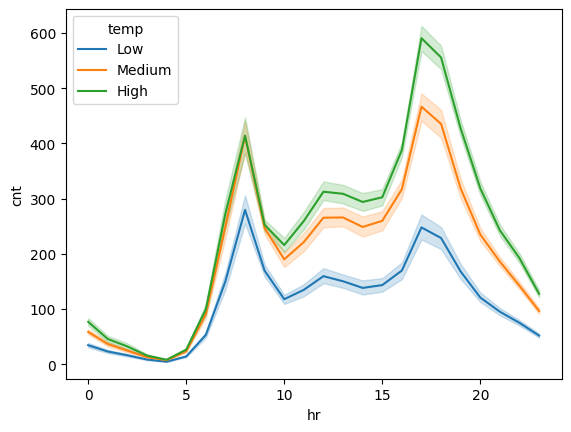

In [1925]:
sns.lineplot(
    data=df,
    x='hr',
    y='cnt',
    hue=pd.qcut(df['temp'], q=3, labels=['Low', 'Medium', 'High'])
)

### Correlation heatmap

Finally, the last EDA step I thought to perform was correlation analysis between the numerical features. Correlation analysis can help identify relationships and provide insights about how they interact. It can also provide important insights when it comes to feature selection, as if two features are highly correlated, one might be redundant and we can remove it and effectively reduce dimensionality. This will be very useful later, during feature selection. 

From the heatmap, I observed:

- temp and atemp have an extremely high correlation of 0.99, confirming the earlier suspicion that one is redundant.

- casual and registered are moderately correlated (0.51), and both are positively correlated with temp and atemp.

- windspeed has very low correlation with all other features, indicating it is fairly independent.

This correlation analysis supports dropping atemp due to redundancy with temp, and confirms the importance of removing casual and registered to avoid data leakage (since we earlier confirmed cnt = casual + registered).

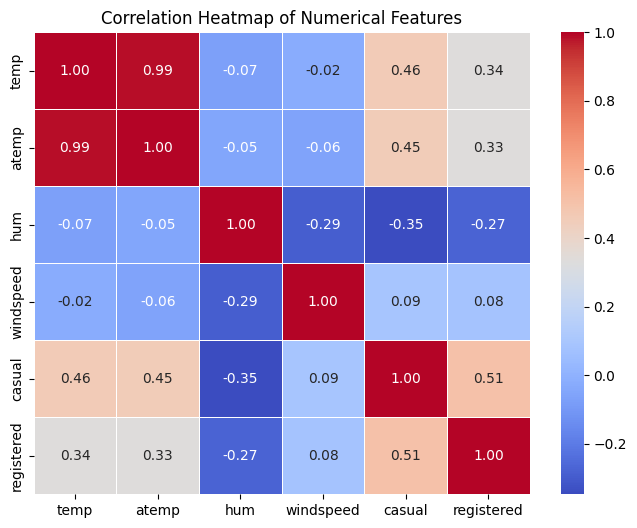

In [1926]:
numerical_features = ["temp", "atemp", "hum", "windspeed", "casual", "registered"]

plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### EDA Summary
Throughout the EDA process, I made decisions with all three models in mind (linear regression, random forest, and random forest) as each has different sensitivities and strengths: 


Linear Regression:
- Skewness and outliers in the target variable and features were checked early, since linear models are sensitive to this.

-  I checked which relationships are linear vs non linear, and noted where transformations may be necessary.

- Dropping atemp (due to high correlation with temp) helps prevent multicollinearity.

- One-hot encoding was identified as the best strategy for categorical features like weekday and season, since linear models can't handle non-numeric or ordinal features effectively.

- Interaction terms were identified, which is especially important for linear regression, which cannot model interactions without explicit feature engineering.

Random forest:
- Trees handle non-linearity and outliers well, so I focused on identifying strong splits (e.g., sharp peaks in hr, drops in weathersit).

- No transformations are required (features like hr, temp, and hum can be used directly).

- Categorical features like season and weekday can be kept as integers because random forest models treat them as discrete values without assuming order.

Gradient Boosting:
- Similar to random forest, Gradient Boosting benefits from clean, non-redundant features.

- Dropping atemp reduces noise and unnecessary complexity.

I also ensured no data leakage by dropping casual and registered, which would have otherwise led to artificially high accuracy.

Although scaling isn’t required, the removal of irrelevant or sparse features (like instant, dteday, and rare weathersit=4) helps avoid overfitting and improves generalization.

### Iteration 2: Additional EDA (task 8)

In the first iteration of feature selection, I removed several features based on high correlation, low mutual information scores, or high VIF values. Specifically, I dropped:
- temp_hum: due to high correlation with temp and high VIF  
- mnth_sin and mnth_cos: due to moderate correlation and redundancy with other month-based encodings  
- season_2 and holiday: due to MI scores of 0  

While these removals followed textbook steps (like eliminating multicollinearity or low relevance), they were based on isolated metrics, which may not reflect how a feature performs in combination with others inside a model.

To re-evaluate some of these decisions, I plotted and analyzed features that were previously dropped:

Initially, I dropped the temp_hum feature due to its high multicollinearity and low mutual information. I explored temp_hum in EDA previously, however it was difficult to visualize if there was truly a change in slope. I revisited this, now increasing the number of humidity bins from 3 to 5 for a more granular analysis. As shown in the updated plot, the relationship between temperature and bike rentals changes noticeably across humidity levels. This variation in slopes confirms the presence of an interaction effect, and justifies reintroducing temp_hum in the next iteration of feature engineering.

<Axes: xlabel='temp', ylabel='cnt'>

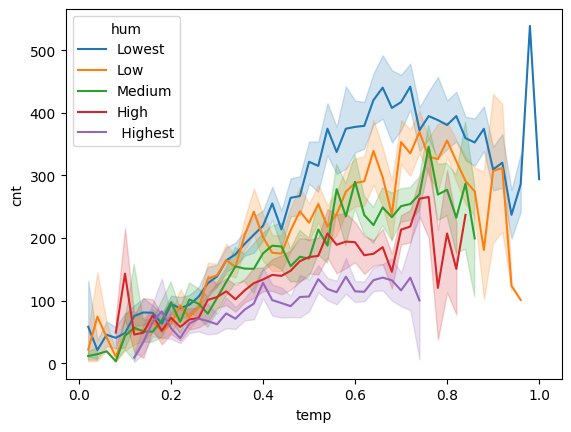

In [1927]:
sns.lineplot(
    data=df,
    x='temp',
    y='cnt',
    hue=pd.qcut(df['hum'], q=5, labels=['Lowest', 'Low', 'Medium', 'High', ' Highest'])
)

I then reanalyzed the effect of a holiday vs non holiday, and observed that rental count does indeed differ. This was already found in EDA previously, but I felt it was important to reemphasize the possibiltiy

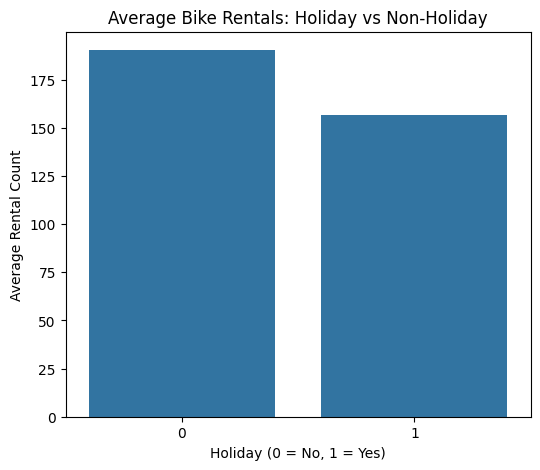

In [1928]:
# Average rentals grouped by holiday
avg_by_holiday = df.groupby("holiday")["cnt"].mean()

# Bar plot
plt.figure(figsize=(6, 5))
sns.barplot(x=avg_by_holiday.index, y=avg_by_holiday.values)
plt.title("Average Bike Rentals: Holiday vs Non-Holiday")
plt.xlabel("Holiday (0 = No, 1 = Yes)")
plt.ylabel("Average Rental Count")
plt.show()

I reanalyzed the effect of season as well, however this time using a lineplot rather than a barplot. This way, I can better visualize trends across seasons rather than just differences. Season 2 and season 4 had pretty similar counts, but vary from the rest. The decision to drop season 2 is still unclear.

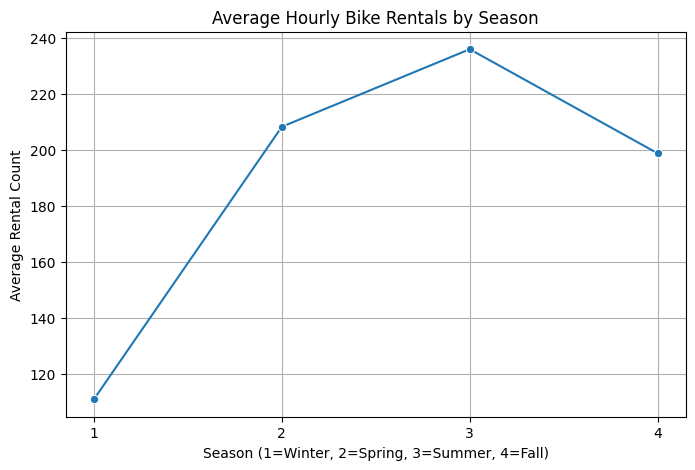

In [1929]:
avg_by_season = df.groupby("season")["cnt"].mean().sort_index()

plt.figure(figsize=(8, 5))
sns.lineplot(x=avg_by_season.index, y=avg_by_season.values, marker='o')
plt.title("Average Hourly Bike Rentals by Season")
plt.xlabel("Season (1=Winter, 2=Spring, 3=Summer, 4=Fall)")
plt.ylabel("Average Rental Count")
plt.grid(True)
plt.xticks([1, 2, 3, 4])
plt.show()

Apart from revisiting the features I had dropped, I also started questioning the ones I kept. In the first round, I primarily used methods like VIF, Pearson correlation, and mutual information, which are designed for continuous variables. Because of this, I didn’t apply strong filtering to most of the categorical or one-hot encoded features, meaning many of them were kept by default.

This made me realize that my earlier approach to feature selection was not comprehensive, especially when it came to evaluating the impact of categorical variables.

To address these limitations, I decided to apply a more structured and model-aware feature selection method during feature engineering: Boruta. Unlike statistical filters, Boruta uses a wrapper approach with a Random Forest to assess the actual importance of each feature in improving prediction accuracy. This allows me to validate (or challenge) my earlier decisions and more confidently select a final feature set moving forward.

# Task 2: Data Splitting

Before performing any feature engineering or scaling, I split the dataset into training (60%), validation (20%), and test sets (20%). This is done early on, as if we scale features before splitting, the mean and standard deviation would be computed from the entire dataset, which means that test data would influence how the training data is transformed, leading to data leakage. The choice of 60 20 20 is based on the fact our dataset is relatively large, hence we can spare some data for validation and testing. This may be reconsidered during hyperparameter tuning.

To avoid leakage and preserve the natural timeline of the data, I began by sorting the data by the date and hour, although it might have already been sorted, as an extra precaution. I did not shuffle the data and use the regular train_test_split function, as this would randomly split the dataset, and maintaining temporal order is crucial when it comes to time sensitive data. Then, I calculated the index positions of the training and validation sets and used array slicing to split the dataset into three sequential parts. After a quick verification of the split sizes, I separated the features (X) and the target variable cnt (Y) for each set.

This way, we ensure a realistic model that mimics real-world scenarios and data leakage is avoided by ensuring the model is trained on earlier data and evaluated on future data.

Although tools like TimeSeriesSplit (skikit-learn) and temporal_train_test_split (sktime) exist for splitting time based data, I chose not to use them for this task for the following reasons:
1. TimeSeriesSplit is designed for time series cross validation, and hence creates folds rather than fixed 60/20/20 splits. To control exact percentages, it would need additional customization and unnecessary complexity.
2. temporal_train_test_split is designed for time series forecasting problems. However, our dataset is tabular data with a time component, and the goal is not to forecase future time steps.

In the end, I decided my manual approach was more appropriate, simpler, and still preserves the timeline of the data.

In [1930]:
# Sort by date and time if not already sorted
df = df.sort_values(by=['dteday', 'hr'])

# Calculate split indices
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split the data
train_df = df[:train_end]
val_df = df[train_end:val_end]
test_df = df[val_end:]

# Verify the split sizes
print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# Separate features and target
X_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']

X_val = val_df.drop('cnt', axis=1)
y_val = val_df['cnt']

X_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt']

Training set size: 10427 (60.0%)
Validation set size: 3476 (20.0%)
Test set size: 3476 (20.0%)


# Task 3: Feature Engineering

### Initial data cleaning

The first step I did was to remove obvious redundancies and issues found in EDA, before employing more technical processing steps. These features were dropped to ensure a clean dataset:

- atemp: Has a 0.99 correlation with temp, making it redundant for model training.
- instant: An ID column, does not provide any useful information for prediction.
- dteday: Date, does not provide any useful information for prediction.
- casual and registered: Components of the target variable cnt (cnt = casual + registered). Keeping them would lead to data leakage, so they were dropped early on.


In [1931]:
# Drop obvious redundancies and leakage-prone columns identified in EDA
cols_to_drop = ['atemp', 'instant', 'dteday', 'casual', 'registered']

for X in [X_train, X_val, X_test]:
    X.drop(columns=cols_to_drop, inplace=True)

Although yr might seem like a temporal feature that risks data leakage, it was intentionally kept because this is not a time-series forecasting problem. We are not predicting future data based on past observations. Instead, we treat yr as a regular categorical indicator that captures long-term trends across the two years in the dataset (2011 and 2012). Its inclusion helps the model account for yearly growth in bike-sharing usage, and it is only available at prediction time, ensuring no leakage of future information.

### Creating New Features


Next, I created features based on relationships identified during EDA.

- temp_hum: This interaction term was added after observing that the effect of temp on bike rentals varied depending on humidity. A grouped lineplot showed that rentals increase more steeply with temperature under low humidity than high humidity.

- hour_workingday: This interaction term captures the difference in hourly rentals between working and non working days. On working days, there is a sharp double peak during commute hours, while on non working days, rentals steadily rise toward the afternoon. This massive change in the shape of the pattern confirmed a strong interaction between hr and workingday.

- mnth_squared: The rental pattern across months followed an upside down u shape. To allow the linear regression model to capture this non linearity, a squared version of mnth was added. Now, the linear model can fit the curve, while tree-based models will simply use the variable as it is or ignore it if unhelpful.

No additional plots were created here since decisions were already thoroughly explained and justified during EDA through plots. This step focused purely on implementation of features already identified as potentially valuable.


In [1932]:
for X in [X_train, X_val, X_test]:
    X['temp_hum'] = X['temp'] * X['hum']
    X['hour_workingday'] = X['hr'] * X['workingday']
    X['mnth_squared'] = X['mnth'] ** 2

### Encoding Cyclical Features & Categorical Variables

Originally, I tried to find the categorical variables using code, by selecting all the object type columns. However, that led to incorrect results, so I manually selected season and weathersit as categorical features instead. Features hr, weekday, and mnth were selected as cyclical features. Although in the assignment, mnth was classified as a categorical variable rather than a cyclic variable, it is truly cyclical in nature hence I grouped it with hr and weekday.

Encoding may be done before or after splitting, but I decided to encode after splitting mainly to avoid data leakage. If we encode then split, info from the test/validation sets would influence training, and then the model would indirectly learn from data it was not supposed to see.

If encoding is done before splitting, we would avoid a common issue: a category that was not in the training set appears in the validation/test sets, causing an error. However there is a way to handle this, which is setting the parameter handle_unknown = "ignore"

To keep the cyclical nature of time related features, I used sine and cosine transformations. These transformations convert the original feature into two new features: sin(feature) and cos(feature), which perserve the periodic patterns of these features. Sin and cos functions are periodic, meaning they tend to repeat their values over a certain interval. Hence, they are the perfect choice for representing cyclical data. They also help avoid discontinuities (for ex, jumpting from december (12) to january (1)).

I considered normalizing the variables first, however as long as I ensured to scale the original feature to the appropriate range (dividing by the cycle length) before applying sin/cos, the transformation itself handles the normalization.

In [1933]:
for X in [X_train, X_val, X_test]:
    # Hour: range 0–23
    X['hr_sin'] = np.sin(2 * np.pi * X['hr'] / 24)
    X['hr_cos'] = np.cos(2 * np.pi * X['hr'] / 24)

    # Weekday: range 0–6
    X['weekday_sin'] = np.sin(2 * np.pi * X['weekday'] / 7)
    X['weekday_cos'] = np.cos(2 * np.pi * X['weekday'] / 7)

    # Month: range 1–12
    X['mnth_sin'] = np.sin(2 * np.pi * X['mnth'] / 12)
    X['mnth_cos'] = np.cos(2 * np.pi * X['mnth'] / 12)

Features season and weathersit were simply one hot encoded, since there exists no order or hierarchy.

To prevent errors in the case that there is a category in the test/validation sets that was not in the training set, the parameter handle_unknown is set to ignore. This ensures that unseen categories in the test set do not cause errors, as they will be ignored. The parameter sparse_output is set to false to return a dataframe rather than a sparse matrix. I set drop= "first" to avoid multicollinearity, which happens when all categories are included as separate columns. By dropping one category, the categories left are compared to the dropped one which becomes a baseline or reference, preventing redundant information in the model.

In [1934]:
# Define encoder
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")

Then, the encoder is fit only on the training data (to avoid data leakage), and we use the same transformation on the test and validation sets. 

In [1935]:
# Fit on training set
X_train_encoded = onehot_encoder.fit_transform(X_train[["season", "weathersit"]])
# Transform val and test sets (DO NOT fit again!)
X_val_encoded = onehot_encoder.transform(X_val[["season", "weathersit"]])
X_test_encoded = onehot_encoder.transform(X_test[["season", "weathersit"]])


The next step is to merge the newly encoded data with the old dataset, however OneHotEncoder outputs a NumPy array instead of a dataframe, which is needed to merge with the original dataset. So, we must assign meaningful names to the new columns. At first I thought to manually rename the columns, however this turned out to be tedious and led to unnecessary errors. Upon further research, I decided to use get_feature_names_out, which automatically generates meaningful column names.

The encoded data is now converted into a dataframe with the appropriate column names.

In [1936]:
# Get new column names for encoded features
encoded_columns = onehot_encoder.get_feature_names_out(["season", "weathersit"])
# Convert to DataFrames with proper column names
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns, index=X_train.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns, index=X_val.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns, index=X_test.index)

I dropped the original columns, and the newly encoded data was then merged with the original dataset.

In [1937]:
# Drop original categorical columns
X_train = X_train.drop(columns=["season", "weathersit", "mnth", "hr", "weekday"])
X_val = X_val.drop(columns=["season", "weathersit", "mnth", "hr", "weekday"])
X_test = X_test.drop(columns=["season", "weathersit", "mnth", "hr", "weekday"])

# Concatenate encoded features with the rest of the dataset
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_val = pd.concat([X_val, X_val_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

Finally, I verified that the dataset shape has changed. I also printed a sample of the dataset to confirm the presence of the encoded categorical features.

In [1938]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("First few rows of X_train:")
print(X_train.head())

X_train shape: (10427, 21)
X_val shape: (3476, 21)
X_test shape: (3476, 21)
First few rows of X_train:
   yr  holiday  workingday  temp   hum  windspeed  temp_hum  hour_workingday  \
0   0        0           0  0.24  0.81        0.0    0.1944                0   
1   0        0           0  0.22  0.80        0.0    0.1760                0   
2   0        0           0  0.22  0.80        0.0    0.1760                0   
3   0        0           0  0.24  0.75        0.0    0.1800                0   
4   0        0           0  0.24  0.75        0.0    0.1800                0   

   mnth_squared    hr_sin  ...  weekday_sin  weekday_cos  mnth_sin  mnth_cos  \
0             1  0.000000  ...    -0.781831      0.62349       0.5  0.866025   
1             1  0.258819  ...    -0.781831      0.62349       0.5  0.866025   
2             1  0.500000  ...    -0.781831      0.62349       0.5  0.866025   
3             1  0.707107  ...    -0.781831      0.62349       0.5  0.866025   
4             1 

One-hot encoding has a significant impact on machine learning models, as it transforms categorical data into a numerical format that models can process. Model predicitons may be distorted if categorical variables are not encoded, because they might be misinterpreted as having a ranking/ordering. This issue is resolved through one-hot encoding, which creates separate binary features for each category. Now, models can handle categorical variables without assuming any implicit ordering or relationships. Linear models in particular benefit from one-hot encoding. For tree based models, one hot encoding adds discrete columns for each category, which helps in creating clean, interpretable splits.

However, it also increases dataset dimensionality and the number of features. Feature selection might be necessary if encoding leads to too many extra features.



Cyclical features like hour, weekday, and month represent data that wraps around. It is very important to handle this type of data carefully, as simply treating it as continuous variables may mislead the model. For example, for hours (0-23), the values 0 and 23 may be treated as distant even though they are actually adjacent. 

By applying sin and cos transformations, we map the values to the range [-1,1], effectively capturing the cyclical nature of the features. Now, the model can recognize for example that 23:00 is close to 00:00, and December is close to January.

For random forest and gradient boosting models, this transformation allows the model to better identify distinct, meaningful splits based on the cyclical feature. For linear models, it allows the model to capture the non linearity of cyclical patterns.

### Feature Scaling

Scaling is a crucial preprocessing step, used to standardize the range of continuous features. Without scaling, features with larger values may dominate during learning, which would lead to biased predictions. 

Linear models are particularly sensitive to the scale of features. This is because they assume all features contribute equally, hence features will larger values or greater variance dominate the learning process. Scaling ensures that each feature contributes the appropriate amount.

For tree based models (such as random forest and gradient boosting), scaling is not actually required, because data is split based on thresholds. Although they are insensitive to the scale of features, it may still help with convergence in some cases, especially with gradient boosting which involves gradient descent.

For this dataset, I opted to use StandardScaler to scale temp, hum, windspeed, temp_hum, hour_workingday, and mnth_squared. Cyclical features were not scaled, since they were already transformed with sin and cos which already maps them to a range of [-1,1].

The choice of StandardScaler made the most sense to me due to a few reasons:
- Since tree based models don't normally require scaling, I focused more on the needs of the linear regression model.
- StandardScaler is generally preferred over other methods, like MinMaxScaler, for linear regression models because it handles features with varying ranges without distorting outliers or data distribution, which could happen with MinMax scaling.

I fit the StandardScaler on the training set only to avoid data leakage, then used the same scaler to transform the validation and test sets. Now, each continuous feature is centered with a mean of 0 and standard deviation of 1.

In [1939]:
# Define columns to scale
scale_cols = ['temp', 'hum', 'windspeed', 'temp_hum', 'hour_workingday', 'mnth_squared']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training set and transform train data
X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

# Transform validation and test data (DO NOT fit again!)
X_val[scale_cols] = scaler.transform(X_val[scale_cols])
X_test[scale_cols] = scaler.transform(X_test[scale_cols])


### Feature selection

Feature selection should be based only on the training data, to correctly simulate real world scenarios, where unseen data is the test data and does not influence any preprocessing decisions. If we were to remove features early on, on the entire dataset, we would end up making choices that don't generalize well.

Selecting the most relevant features is very important to simplify the model and remove redundant/irrelevant features, which would efftectively lead to a more understandable and interpretable model. It also decreases the chance of overfitting. 
I employed a few different methods to help me select the most important features:

Variance Threshold:

The first method I tested was the variance threshold method, checking if any features have an extremely low variance (meaning they provide very little info to the model). First, I printed the variance of each feature, to better understand what I am dealing with. Then, I set a threshold of 0.01 as a baseline for what I considered to be "too low". I chose this number as a general rule of thumb I found from researching.

In my case, feature "weathersit_4" was removed, which represented a rare category in the weathersit category, which only had 3 entries..

In [1940]:
# variance for each feature
feature_variances = X_train.var()
print("Feature Variances:")
print(feature_variances.sort_values(ascending=True))

Feature Variances:
weathersit_4       0.000288
holiday            0.028759
weathersit_3       0.081323
yr                 0.141708
season_4           0.162790
season_2           0.166656
season_3           0.168692
weathersit_2       0.190374
workingday         0.216589
mnth_cos           0.478818
hr_sin             0.499270
weekday_sin        0.499561
mnth_sin           0.499876
weekday_cos        0.500527
hr_cos             0.500765
hum                1.000096
temp_hum           1.000096
windspeed          1.000096
mnth_squared       1.000096
hour_workingday    1.000096
temp               1.000096
dtype: float64


In [1941]:
# variance threshold
threshold = 0.01

# low variance features
low_variance_features = feature_variances[feature_variances < threshold].index

# drop low variance features
X_train = X_train.drop(columns=low_variance_features)
X_val = X_val.drop(columns=low_variance_features)
X_test = X_test.drop(columns=low_variance_features)

print("Dropped low variance features:", low_variance_features.tolist())

Dropped low variance features: ['weathersit_4']


Feature Correlation:

The next method I used was removing highly correlated features, as high correlation implies redundancy since one feature predicts the other. Upon research, I came to understand: 
- very strong correlation from 0.80 to 1.00
- strong correlation from 0.60 to 0.80 
- moderate correlation from 0.40 to 0.60
- weak correlation from 0.20 to 0.40
- very weak correlation from 0.00 to 0.20

At first, I wanted to create a correlation heatmap just as I did in EDA, however there are too many features for a heatmap to be easily interpretable. Instead, I checked Pearson correlation using .corr and printed the strongly correlated features. Based on what I explained above, I chose 0.6 as a threshold for strongly correlated features. Pearson correlation is done only with continuous numerical features, hence I added a condition in the code X_train.nunique() > 2 to remove binary features from the calculation.

I observed:
- temp and temp_hum have a correlation of 0.76, which makes sense since temp_hum is partly derived from temp
- mnth_squared and mnth_sin have a correlation of 0.73, which makes sense since mnth_squared is derived from mnth (and mnth_sin is part of the encoded version of mnth)
- temp and mnth_cos have a correlation of 0.73

In [1942]:
X_numeric = X_train.loc[:, X_train.nunique() > 2]  # filters out one-hot/binary

# compute correlation matrix
corr_matrix = X_numeric.corr().abs()

# get upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# print pairs with correlation > 0.60
print("Highly correlated feature pairs (corr > 0.60):\n")
for col in upper.columns:
    for row in upper.index:
        if upper.loc[row, col] > 0.60:
            print(f"{row} and {col}: {upper.loc[row, col]:.2f}")


Highly correlated feature pairs (corr > 0.60):

temp and temp_hum: 0.76
mnth_squared and mnth_sin: 0.73
temp and mnth_cos: 0.73


To help decide which of the correlated features to drop, I used Mutual Information Scores, VIF, and general domain knowledge. The higher the MI score, the more the feature tells you about the target, and the higher the VIF, the more redundant the feature.

- temp MI & VIF: 0.14 & 14.53, temp_hum MI & VIF: 0.07 & 18.36 -> drop temp_hum
- mnth_squared MI & VIF: 0.06 & 4.2, mnth_sin MI & VIF: 0.05 & 5.67 -> drop mnth_sin
- temp MI & VIF: 0.14 & 14.53, mnth_cos MI & VIF: 0.04 & 7.06. Although the VIF of temp is higher, from general dataset knowledge and logic, temperature is an important indicator for the number of hourly bike rentals. -> drop mnth_cos

Results from MI scores also showed 0 for season_2 and holiday, hence I decided to drop them as well.

In [1943]:
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)

# create a series with feature names and scores
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# print ranked features
print("Mutual Information Scores (higher = more predictive):\n")
print(mi_series)


Mutual Information Scores (higher = more predictive):

hour_workingday    0.645880
hr_sin             0.360794
hr_cos             0.360029
temp               0.141124
hum                0.101749
temp_hum           0.072711
mnth_squared       0.051507
mnth_sin           0.044174
mnth_cos           0.029744
weekday_sin        0.026828
workingday         0.024648
season_3           0.021069
weathersit_3       0.016012
weekday_cos        0.010309
windspeed          0.008595
season_4           0.003751
yr                 0.003503
weathersit_2       0.002056
holiday            0.000000
season_2           0.000000
dtype: float64


In [1944]:
# step 1: select only numeric features
X_numeric = X_train.select_dtypes(include=["int64", "float64"])

# step 2: drop binary features (those with only 2 unique values)
X_continuous = X_numeric.loc[:, X_numeric.nunique() > 2]

# step 3: calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_continuous.columns
vif_data["VIF"] = [variance_inflation_factor(X_continuous.values, i) for i in range(X_continuous.shape[1])]

# step 4: sort and view
print(vif_data.sort_values(by="VIF", ascending=False))


            feature        VIF
3          temp_hum  18.074362
0              temp  13.990086
1               hum   7.642348
11         mnth_cos   3.626471
10         mnth_sin   3.212545
5      mnth_squared   2.658996
4   hour_workingday   2.095773
6            hr_sin   1.761411
9       weekday_cos   1.555411
7            hr_cos   1.177374
2         windspeed   1.149152
8       weekday_sin   1.106845


In [1945]:
features_to_drop = ["temp_hum", "mnth_sin", "mnth_cos", "season_2", "holiday"]

# drop from all datasets
X_train = X_train.drop(columns=features_to_drop)
X_val = X_val.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)


### Iteration 2: boruta (task 8)

First, I began by readding all the dropped features back to X_train to create other sets for my second iteration.

In [1946]:
# Use the original df to recreate dropped engineered features

# Add back 'holiday'
X_train['holiday'] = df.loc[X_train.index, 'holiday']
X_val['holiday']   = df.loc[X_val.index, 'holiday']
X_test['holiday']  = df.loc[X_test.index, 'holiday']

# temp_hum = temp * hum
X_train['temp_hum'] = df.loc[X_train.index, 'temp'] * df.loc[X_train.index, 'hum']
X_val['temp_hum']   = df.loc[X_val.index, 'temp'] * df.loc[X_val.index, 'hum']
X_test['temp_hum']  = df.loc[X_test.index, 'temp'] * df.loc[X_test.index, 'hum']

# mnth_sin and mnth_cos
X_train['mnth_sin'] = np.sin(2 * np.pi * df.loc[X_train.index, 'mnth'] / 12)
X_val['mnth_sin']   = np.sin(2 * np.pi * df.loc[X_val.index, 'mnth'] / 12)
X_test['mnth_sin']  = np.sin(2 * np.pi * df.loc[X_test.index, 'mnth'] / 12)

X_train['mnth_cos'] = np.cos(2 * np.pi * df.loc[X_train.index, 'mnth'] / 12)
X_val['mnth_cos']   = np.cos(2 * np.pi * df.loc[X_val.index, 'mnth'] / 12)
X_test['mnth_cos']  = np.cos(2 * np.pi * df.loc[X_test.index, 'mnth'] / 12)

# season_2 and weathersit_4 from one-hot encoding
season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=False)
weathersit_dummies = pd.get_dummies(df['weathersit'], prefix='weathersit', drop_first=False)

X_train['season_2'] = season_dummies.loc[X_train.index, 'season_2']
X_val['season_2']   = season_dummies.loc[X_val.index, 'season_2']
X_test['season_2']  = season_dummies.loc[X_test.index, 'season_2']

X_train['weathersit_4'] = weathersit_dummies.loc[X_train.index, 'weathersit_4']
X_val['weathersit_4']   = weathersit_dummies.loc[X_val.index, 'weathersit_4']
X_test['weathersit_4']  = weathersit_dummies.loc[X_test.index, 'weathersit_4']


I double checked all the appropriate columns were back

In [1947]:
print(X_train.columns.tolist())


['yr', 'workingday', 'temp', 'hum', 'windspeed', 'hour_workingday', 'mnth_squared', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'season_3', 'season_4', 'weathersit_2', 'weathersit_3', 'holiday', 'temp_hum', 'mnth_sin', 'mnth_cos', 'season_2', 'weathersit_4']


Then, I employed boruta and let it completely decide which features should stay and go. 

Boruta identified 14 confirmed features and rejecting 7. The selected features included a mix of temporal (hr_sin, hr_cos, weekday_sin), weather-related (temp, hum, windspeed, temp_hum), and categorical features like season_4 and weathersit_3. Notably, features like temp_hum and mnth_sin, which had previously been dropped, were retained — validating their potential contribution.

In [1948]:
# Initialize the base model for Boruta (you can change n_estimators if needed)
rf_for_boruta = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

# Initialize Boruta
boruta_selector = BorutaPy(
    estimator=rf_for_boruta,
    n_estimators='auto',
    random_state=42,
    verbose=1
)

# Fit Boruta on training data
boruta_selector.fit(X_train.values, y_train.values)

# Get the selected features
selected_features = X_train.columns[boruta_selector.support_].tolist()
print("Selected features by Boruta:")
print(selected_features)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	7
Selected features by Boruta:
['yr', 'workingday', 'temp', 'hum', 'windspeed', 'hour_workingday', 'mnth_squared', 'hr_sin', 'hr_cos', 'weekday_sin', 'season_4', 'weathersit_3', 'temp_hum', 'mnth_sin']


I created X_train/val/test_boruta from X_train, using only the features boruta selected.

In [1949]:
X_train_boruta = X_train[selected_features]
X_val_boruta = X_val[selected_features]
X_test_boruta = X_test[selected_features]

Finally, I dropped the features again, to keep my feature selection and borutas feature selection separate for analysis of which performs better

In [1950]:
features_to_drop = ["temp_hum", "mnth_sin", "mnth_cos", "season_2", "holiday", "weathersit_4"]

# drop from all datasets
X_train = X_train.drop(columns=features_to_drop)
X_val = X_val.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [1951]:
print(X_train.columns.tolist())

['yr', 'workingday', 'temp', 'hum', 'windspeed', 'hour_workingday', 'mnth_squared', 'hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos', 'season_3', 'season_4', 'weathersit_2', 'weathersit_3']


# Task 4: Baseline Model – Linear Regression

To establish a baseline for model comparison, I used a linear regression model. Linear regression is a simple, interpretable algorithm that assumes linear relationship between features and the target. It can't really capture complex, nonlinear patterns in the data but it provides a good benchmark to evaluate the effectiveness of more advanced models. The model was trained on the chronologically split training set, and evaluated on the validation set using various metrics. Although it is simple, linear regression serves as a reference point for assessing improvements made by tree-based methods.

In [1952]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

The linear regression model has an MSE of 29200.06, meaning the average squared error between predictions and actual values was quite large. Its RMSE of 170.88 tells us that, on average, the model’s predictions were off by about 171 bike rentals. The MAE of 124.45 shows the average absolute error, regardless of whether the prediction was too high or too low.

The R² score was just 0.37, which means the model was only able to explain 37% of the variation in bike rental counts. This low score suggests the model missed most of the key patterns. The MAPE of 262.02% shows that the model’s percentage error was often very large.

These results confirm that linear regression underfits the data, failing to capture the nonlinear patterns of hourly bike rentals. There is a need for more flexible models, which will be used in the next tasks.

In [1953]:
y_val_pred = lr_model.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

print(f"Linear Regression - MSE: {mse:.2f}")
print(f"Linear Regression - MAE: {mae:.2f}")
print(f"Linear Regression - R²: {r2:.2f}")
print(f"Linear Regression - RMSE: {rmse:.2f}")
print(f"Linear Regression - MAPE: {mape:.2f}%")


Linear Regression - MSE: 29200.06
Linear Regression - MAE: 124.45
Linear Regression - R²: 0.37
Linear Regression - RMSE: 170.88
Linear Regression - MAPE: 262.02%


The residual distribution for the linear regression model is zero clearly right-skewed. This suggests the model frequently underpredicts the number of bike rentals. The residuals aren't following a symmetric, bell-shaped curve, which violates the assumption of normally distributed errors. This skewed distribution, along with the heavy tail of large positive residuals, confirms that the model struggles to capture high rental values. This is another sign of underfitting and limited capacity to model complex patterns in the data.

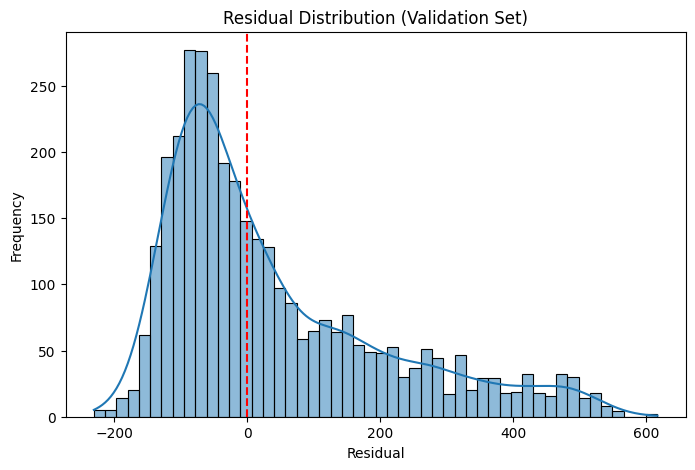

In [1954]:
residuals = y_val - y_val_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Validation Set)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()


The actual vs. predicted scatter plot shows a clear pattern of underprediction, more specifically for higher rental counts. While predictions generally increase with actual values, they seem to stop changing around 400, even when the actual rentals exceed 800. This suggests that the linear regression model is unable to capture nonlinear trends in the data, such as spikes during rush hours or weather effects.

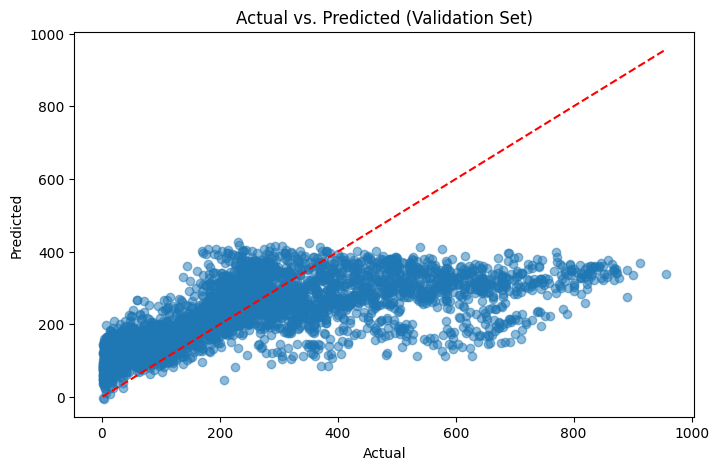

In [1955]:
plt.figure(figsize=(8, 5))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted (Validation Set)")
plt.show()


A model with high bias and low variance, also known as underfitting, is a model that is too simple to capture the underlying patterns in the data. This occurs because the model is not flexible enough to adapt to the complexities of the dataset. The linear regression model shows high bias and low variance. This is shown through its poor performance across all the evaluation metrics and its inability to capture the nonlinear relationships in the data. The model makes consistently inaccurate predictions regardless of the data subset, which suggests underfitting caused by high bias. However, the predictions are relatively stable, and don’t fluctuate too much between validation samples, indicating low variance. This tradeoff suggests that the model is too simple and we may require a model that is better suited for this task.

### Iteration 2:

After applying Boruta, the linear regression model showed a slight improvement in performance. The R² score increased from 0.37 to 0.38, while the MAE and RMSE both decreased. MAPE also dropped from 262.02% to 251.63%, indicating fewer extreme percentage errors, especially on low rental counts. Although the gains were small, this suggests that even a simple linear model can benefit from more structured feature selection, as Boruta helped eliminate redundant or uninformative variables that may have introduced noise.

In [1956]:
lr_model = LinearRegression()
lr_model.fit(X_train_boruta, y_train)

LinearRegression()

In [1957]:
y_val_pred = lr_model.predict(X_val_boruta)

mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100

print(f"Linear Regression - MSE: {mse:.2f}")
print(f"Linear Regression - MAE: {mae:.2f}")
print(f"Linear Regression - R²: {r2:.2f}")
print(f"Linear Regression - RMSE: {rmse:.2f}")
print(f"Linear Regression - MAPE: {mape:.2f}%")

Linear Regression - MSE: 28966.96
Linear Regression - MAE: 123.37
Linear Regression - R²: 0.38
Linear Regression - RMSE: 170.20
Linear Regression - MAPE: 251.63%


# Task 5: Random Forest Regressor - Model Specification and Training

To improve from baseline model (linear regression), I trained a Random Forest Regressor, which is an ensemble learning method that builds multiple decision trees and averages their predictions. Unlike linear regression, Random Forest can model complex, nonlinear relationships and automatically capture interactions between features. It also reduces overfitting through the use of bagging and random feature selection. This makes it a strong option for our prediction task, where bike rentals are influenced by a mix of temporal, weather, and categorical factors. Here, I used the default parameters (100 trees, no depth limit) to establish a performance baseline and compared it to the linear model.

In [1958]:
rf_model = RandomForestRegressor(random_state=42)  # defaults to 100 trees, no depth limit
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

The Random Forest model did much better than the baseline linear regression. It had an MSE of 10101.04 and an RMSE of 100.50, so a much lower average prediction error compared to the baseline. The MAE of 71.18 is almost half the error of linear regression (124.45). The R² score of 0.78 shows that the moded explained 78% of the variance in bike rental counts, which is more than double the 37% explained by the linear model. Additionally, the MAPE decreased from 262.02% to 32.20%, showing that the Random Forest model handled relative errors much better, especially when rental volumes were low. These results confirm that Random Forest is much better at capturing the nonlinear and complex relationships in the data.

In [1959]:
y_val_pred_rf = rf_model.predict(X_val)

mse_rf = mean_squared_error(y_val, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = np.mean(np.abs((y_val - y_val_pred_rf) / y_val)) * 100

print(f"Random Forest - MSE: {mse_rf:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - R²: {r2_rf:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - MAPE: {mape_rf:.2f}%")


Random Forest - MSE: 10101.04
Random Forest - MAE: 71.18
Random Forest - R²: 0.78
Random Forest - RMSE: 100.50
Random Forest - MAPE: 32.20%


The residual distribution for the Random Forest model is much tighter and more symmetric compared to the linear regression model. Most residuals are concentrated around zero, with fewer extreme errors on either side. There is still a slight right skew, but its way less, so the model handles high rental values better than the linear baseline. The narrow peak and smaller spread suggest lower variance in prediction errors. Overall, this distribution shows that Random Forest provides more reliable predictions across different rental levels.



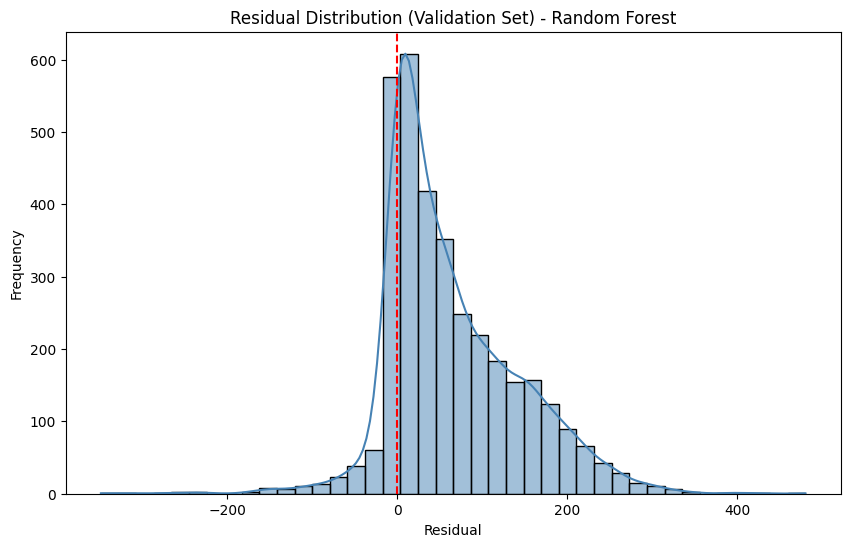

In [1960]:
# residual plot
residuals_rf = y_val - y_val_pred_rf
plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, bins=40, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution (Validation Set) - Random Forest")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

The Actual vs. Predicted plot for the Random Forest model shows a pretty good alignment between the predicted and actual values, as most points cluster closely around the diagonal reference line. This means there is high predictive accuracy across a wide range of rental counts. The spread of points is tighter compared to the linear regression model, specifically at higher values, meaning the model performs well even when demand is high. There are a few outliers still exist, especially at higher counts, but the overall pattern suggests that Random Forest captures the underlying trends way better than simpler models.

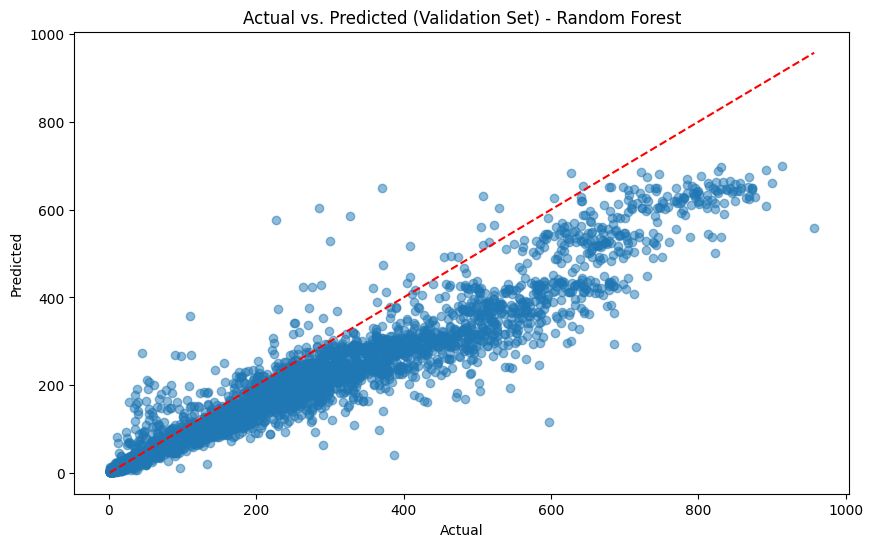

In [1961]:
# actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted (Validation Set) - Random Forest")
plt.show()


The feature importance plot shows that hr_cos and hr_sin, which represent the cyclical transformation of the hour feature, were the most influential predictors in the Random Forest model. This confirms that the time of day strongly impacts bike rental patterns. The combined feature hour_workingday also ranked highly, suggests that the interaction between hour and whether it's a working day also strongly impacts the target. Weather-related variables like temp and hum were also important too, reflecting the influence of environmental conditions on rental behavior. Interestingly, yr still contributed some value, possibly capturing broader temporal shifts like growth in bike usage over time. Overall, the model prioritized time and weather variables, aligning well with domain expectations.

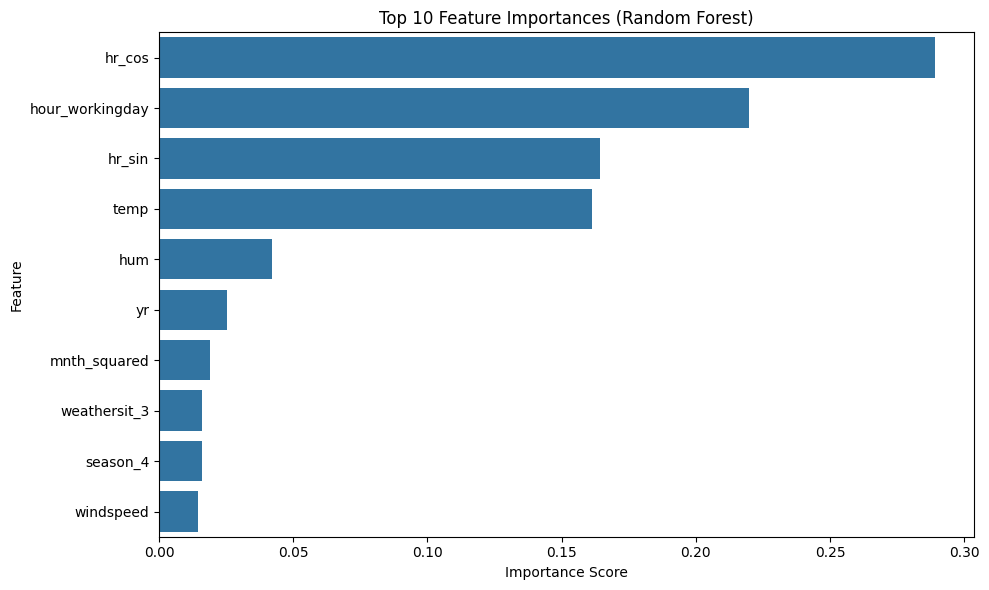

In [1962]:
# get importance values
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


To further check feature relevance, I computed permutation importance using the validation set. This checks each feature’s contribution to model performance by checking how the R² score drops when the feature’s values are randomly shuffled. The results validated earlier findings: hr_cos, hour_workingday, and hr_sin were the top contributors, showing the model relies heavily on hourly patterns and whether a given hour is part of a working day.

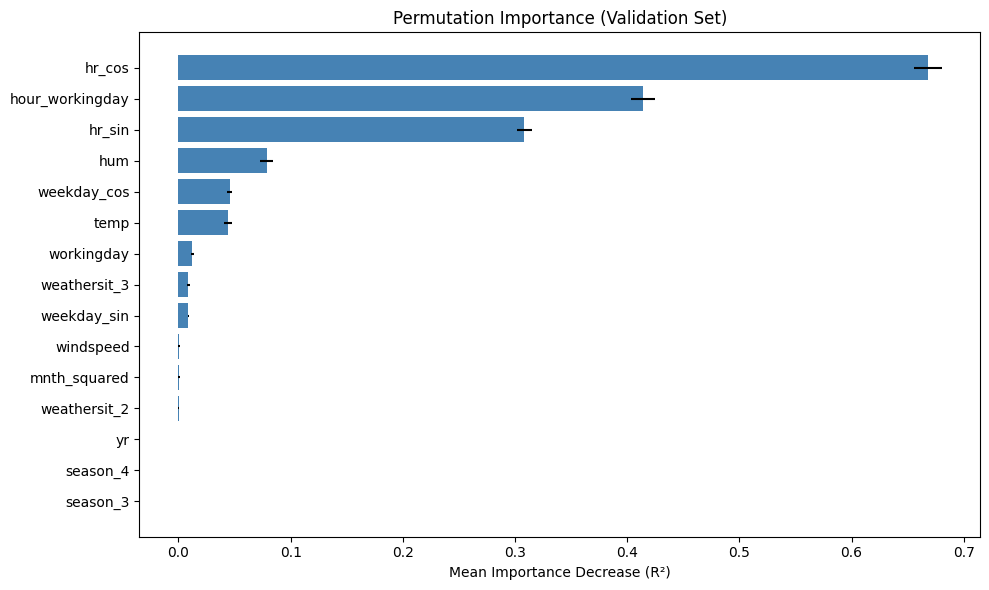

In [1963]:
# run permutation importance on the validation set
perm_result = permutation_importance(rf_model, X_val, y_val, n_repeats=10, random_state=42, scoring='r2')

# convert to DataFrame
perm_df = pd.DataFrame({
    'feature': X_val.columns,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# plot
plt.figure(figsize=(10, 6))
plt.barh(perm_df['feature'], perm_df['importance_mean'], xerr=perm_df['importance_std'], color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel("Mean Importance Decrease (R²)")
plt.title("Permutation Importance (Validation Set)")
plt.tight_layout()
plt.show()


### Iteration 2:

After applying Boruta, the Random Forest model slightly underperformed compared to the original version. The R² score dropped from 0.78 to 0.77, and both MAE and RMSE increased slightly. MAPE also rose from 32.20% to 32.63%. Although Boruta reduced the feature set to only the most statistically significant variables, it may have removed features that Random Forest was still able to use effectively through its ensemble structure. This showed me that while Boruta can be helpful in filtering noise, in this case, the original model with more features actually generalized better.

In [1964]:
rf_model = RandomForestRegressor(random_state=42)  # defaults to 100 trees, no depth limit
rf_model.fit(X_train_boruta, y_train)

RandomForestRegressor(random_state=42)

In [1965]:
y_val_pred_rf = rf_model.predict(X_val_boruta)

mse_rf = mean_squared_error(y_val, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mape_rf = np.mean(np.abs((y_val - y_val_pred_rf) / y_val)) * 100

print(f"Random Forest - MSE: {mse_rf:.2f}")
print(f"Random Forest - MAE: {mae_rf:.2f}")
print(f"Random Forest - R²: {r2_rf:.2f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}")
print(f"Random Forest - MAPE: {mape_rf:.2f}%")


Random Forest - MSE: 10821.31
Random Forest - MAE: 74.02
Random Forest - R²: 0.77
Random Forest - RMSE: 104.03
Random Forest - MAPE: 32.63%


# Task 6: Gradient Boosting Regressor - Model Specification and Training

To attempt to improve performance even more, a Gradient Boosting Regressor was trained as the third model. Gradient Boosting is a powerful ensemble technique that builds models sequentially, where each new model attempts to correct the errors made by the previous ones. To do this I used XGBoost in specific, a widely adopted implementation of gradient boosting. This model is especially well-suited for capturing complex, nonlinear relationships in the data, making it a strong candidate for modeling hourly bike rental patterns. Basic parameters were used initially to establish a performance baseline and allow comparison with the previous models.

In [1966]:
# initialize with basic parameters
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
# train on training set
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

The XGBoost model did better than both the Linear Regression and Random Forest models. It has an MSE of 7,409.02 and an RMSE of 86.08, indicating a much lower average prediction error. The MAE of 62.07 shows that, on average, predictions were off by just 62 bike rentals—an improvement over Random Forest (71.23) and Linear Regression (124.47). The R² score increased to 0.84, meaning the model was able to explain 84% of the variance in rental counts (in comparison to 37% and 78% for the linear and random forest models). Although the MAPE is still relatively high at 51.77%, this is still a huge reduction from the 262.62% of the linear model. Overall, these results suggest that XGBoost is highly effective in modeling the nonlinear and complex patterns in the data.

In [1967]:
# predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val)

# evaluate performance
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
r2_xgb = r2_score(y_val, y_val_pred_xgb)
mape_xgb = np.mean(np.abs((y_val - y_val_pred_xgb) / y_val)) * 100

print(f"XGBoost - MSE: {mse_xgb:.2f}")
print(f"XGBoost - MAE: {mae_xgb:.2f}")
print(f"XGBoost - R²: {r2_xgb:.2f}")
print(f"XGBoost - RMSE: {rmse_xgb:.2f}")
print(f"XGBoost - MAPE: {mape_xgb:.2f}%")


XGBoost - MSE: 7409.02
XGBoost - MAE: 62.07
XGBoost - R²: 0.84
XGBoost - RMSE: 86.08
XGBoost - MAPE: 51.77%


The residual distribution for the XGBoost model is sharply centered around zero, with a narrow and tall peak, so most predictions were close to the actual values. Compared to previous attempts, the distribution is more symmetric, so improved prediction accuracy. While a slight right skew remains, it's much less pronounced than in the linear or random forest models. The reduced spread and fewer extreme residuals point to lower variance and better generalization. These patterns align with the model's high R² score and low error metrics, showing that XGBoost captures the underlying structure of the data effectively without severe underfitting or overfitting.

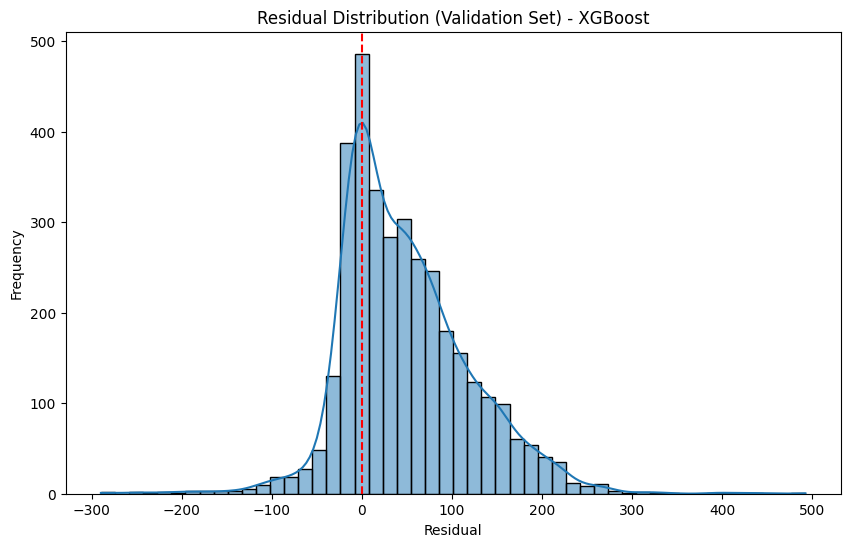

In [1968]:
# residuals
residuals_xgb = y_val - y_val_pred_xgb

plt.figure(figsize=(10, 6))
sns.histplot(residuals_xgb, bins=50, kde=True,)
plt.axvline(0, color='red', linestyle='--')
plt.title("Residual Distribution (Validation Set) - XGBoost")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


The actual vs. predicted plot for the XGBoost model shows points closely clustered around the diagonal line, so a strong alignment between predicted and actual rental counts. While some scatter is still there (especially at higher values) the predictions generally track the true values well across the full range. This visual pattern supports the model’s high R² score of 0.84 and low error metrics, confirming that XGBoost captures complex relationships in the data more effectively than the other models.

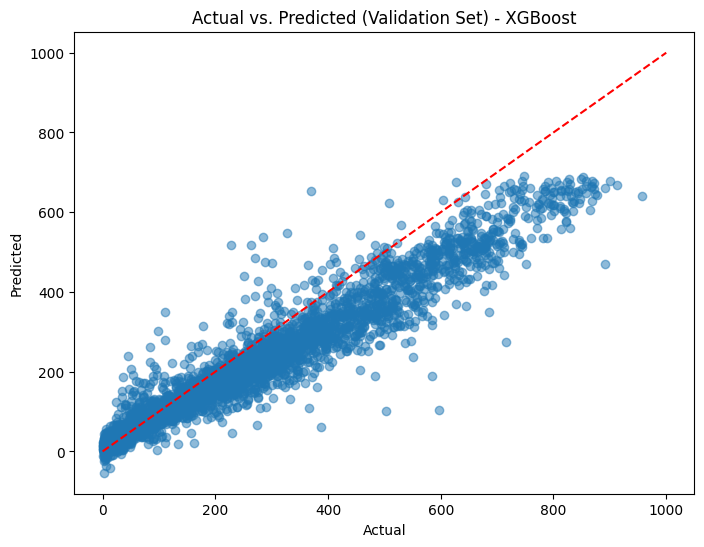

In [1969]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred_xgb, alpha=0.5)
plt.plot([0, 1000], [0, 1000], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted (Validation Set) - XGBoost")
plt.show()

Although XGBoost performed well on the validation set with an R² of 0.84 and relatively low errors, there are small signs of early overfitting. The residual distribution, while centered near zero, has a slight right skew, indicating that the model occasionally makes larger errors, especially on higher counts. The actual vs. predicted plot also shows some underestimation for high rental values, which could suggest that the model is slightly overfitting to common patterns in the training data and struggling to generalize to less frequent scenarios. However, these signs are relatively mild and may be improved with further tuning.

### Iteration 2:

Using Boruta with XGBoost resulted in slightly worse performance compared to the original tuned model. The R² score decreased from 0.84 to 0.83, and all error metrics—including MAE, RMSE, and MAPE—were slightly higher. Notably, MAPE rose from 51.77% to 40.67%, suggesting that the Boruta-selected features improved relative error handling but may have sacrificed overall precision. While the difference is minor, it indicates that Boruta's strict filtering might have removed features that XGBoost could still benefit from due to its ability to model complex feature interactions.

In [1970]:
# initialize with basic parameters
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
# train on training set
xgb_model.fit(X_train_boruta, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [1971]:
# predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_boruta)

# evaluate performance
mse_xgb = mean_squared_error(y_val, y_val_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
r2_xgb = r2_score(y_val, y_val_pred_xgb)
mape_xgb = np.mean(np.abs((y_val - y_val_pred_xgb) / y_val)) * 100

print(f"XGBoost - MSE: {mse_xgb:.2f}")
print(f"XGBoost - MAE: {mae_xgb:.2f}")
print(f"XGBoost - R²: {r2_xgb:.2f}")
print(f"XGBoost - RMSE: {rmse_xgb:.2f}")
print(f"XGBoost - MAPE: {mape_xgb:.2f}%")


XGBoost - MSE: 7959.83
XGBoost - MAE: 63.35
XGBoost - R²: 0.83
XGBoost - RMSE: 89.22
XGBoost - MAPE: 40.67%


# Task 7: Hyperparameter Tuning

In this task, I tuned the hyperparameters of both the Random Forest and XGBoost models to improve their performance on the validation set. Hyperparameter tuning was done using cross-validation with TimeSeriesSplit, to preserve temporal order and prevent leakage from future data into the past. The goal was to optimize performance without overfitting, while maintaining fair and realistic model evaluation.

### Random Forest

tscv = TimeSeriesSplit(n_splits=5) creates a time-aware cross-validation strategy where each split trains on past data and validates on future data, preventing data leakage.

param_dist is the search space for the tuner, defining a range of values for:
- n_estimators: Number of trees in the forest
- max_depth: Maximum depth of each tree
- min_samples_split: Minimum number of samples needed to split a node
- min_samples_leaf: Minimum number of samples required to be at a leaf node
These are the four hyperparameters to be tuned

RandomizedSearchCV performs the actual hyperparameter tuning by:
- Randomly testing 50 different combinations from your search space
- Using TimeSeriesSplit for validation
- Evaluating each combo with R² score (scoring='r2')
- Choosing the combination with the highest average R² across the 5 splits

In [1972]:
tscv = TimeSeriesSplit(n_splits=5)

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # or fewer for faster results
    cv=tscv,
    scoring='r2',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='r2', verbose=2)

After performing hyperparameter tuning using RandomizedSearchCV with TimeSeriesSplit, the best Random Forest configuration included:
- n_estimators = 500
- max_depth = None
- min_samples_split = 2
- min_samples_leaf = 1

The model achieved the following performance on the validation set:
- MSE: 10,027.13
- MAE: 71.03
- R²: 0.78

These results are very similar to the untuned Random Forest model, suggesting that the default settings were already close to optimal for this dataset. The tuning confirmed that a large ensemble with full-depth trees and minimal constraints on splits continued to perform well. This also highlights the stability and robustness of Random Forest for this type of problem, even with relatively minimal tuning. No signs of overfitting were observed, and performance remained consistent across validation folds.


In [1973]:
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_


y_val_pred = best_rf.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Tuned Random Forest - MSE: {mse:.2f}")
print(f"Tuned Random Forest - MAE: {mae:.2f}")
print(f"Tuned Random Forest - R²: {r2:.2f}")


Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Tuned Random Forest - MSE: 10027.13
Tuned Random Forest - MAE: 71.03
Tuned Random Forest - R²: 0.78


After tuning the Random Forest model, I checked feature importance again to see any changes in how the model weighs predictors. The top features remained largely consistent, with hr_cos, hour_workingday, hr_sin, and temp continuing to dominate, emphasizing the strong influence of cyclical time patterns and temperature on bike rental behavior.

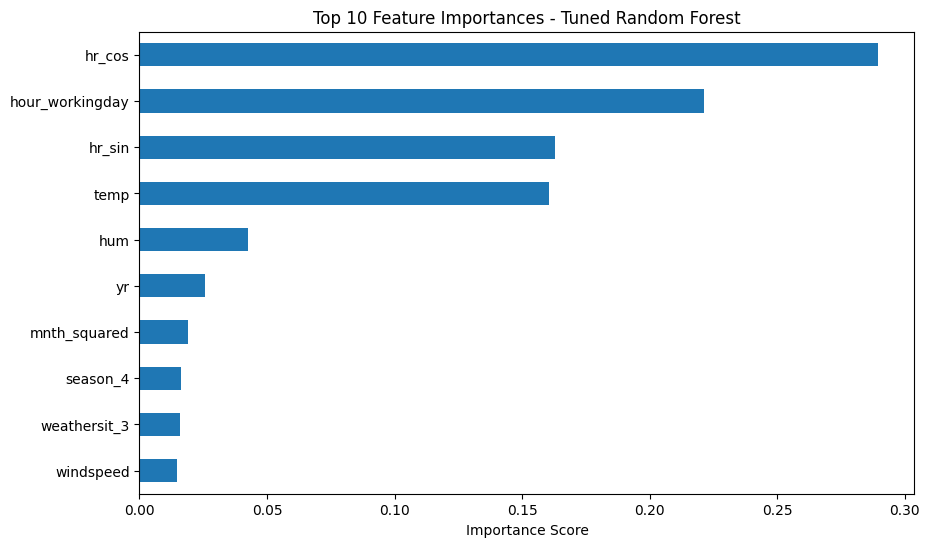

In [1974]:
importances = best_rf.feature_importances_
features = X_train.columns
fi_rf = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
fi_rf.head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances - Tuned Random Forest")
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.show()


### Gradient Boosting

Again, tscv creates a time-aware cross-validation strategy where each split trains on past data and validates on future data, preventing data leakage.

search_space defines the hyperparameters we need to tune:
- learning_rate: Step size shrinkage to prevent overfitting
- n_estimators: Number of boosting rounds (trees)
- max_depth: Maximum depth of each tree
- subsample: Fraction of training samples used per tree (for regularization)

BayesSearchCV performs hyperparameter tuning by:
- Selecting 50 hyperparameter combinations using Bayesian optimization
- Using TimeSeriesSplit for realistic validation
- Scoring each combination using R² (scoring='r2')
- Selecting the combination with the highest average R² across all splits

In [1975]:
# use a time-aware cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

search_spaces = {
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'n_estimators': (100, 500),
    'max_depth': (3, 10),
    'subsample': (0.5, 1.0, 'uniform')
}

xgb = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
    n_jobs=-1
)


opt = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=50,      
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='rmse', feature_types=None,
                                     feature_weights=None, gamma=N...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='r2',
              search_spaces={'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (100, 500),
                             'subsample': (0.5, 1.0, 'uniform')},
              verbose=1)

This convergence plot shows the mean R² score across 50 iterations of Bayesian hyperparameter tuning. While not a formal convergence plot (since BayesSearchCV doesn’t support native convergence tracking), it gives a good sense of optimizer performance over time. Despite a few noisy dips, the overall trend stabilizes over time, with many of the later iterations consistently achieving high validation scores. This suggests that the optimizer successfully explored the parameter space and converged toward a well-performing region. The occasional sharp drops reflect exploration steps, which are expected in Bayesian optimization.

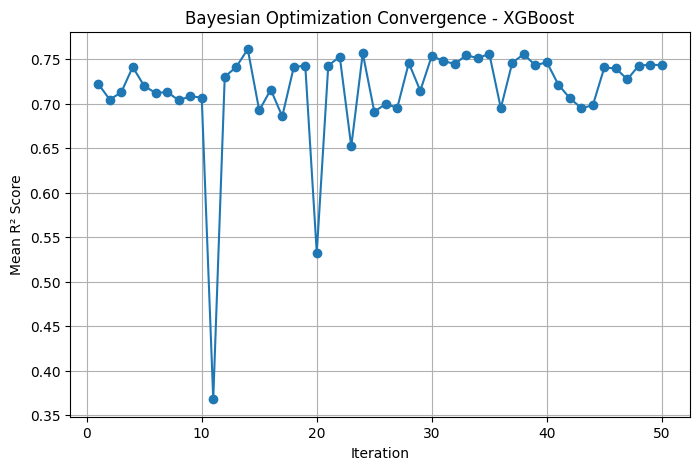

In [1976]:
# extract best score from each iteration (in order)
scores = opt.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(scores) + 1), scores, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Mean R² Score")
plt.title("Bayesian Optimization Convergence - XGBoost")
plt.grid(True)
plt.show()

After tuning the XGBoost model with BayesSearchCV and TimeSeriesSplit, the best combination of hyperparameters found was:
- learning_rate = 0.16
- max_depth = 3
- n_estimators = 500
- subsample = 0.5

The tuned model managed to achieve these metrics:
- MSE: 5728.41
- MAE: 52.59
- RSME: 75.69
- R²: 0.88

These results show a clear improvement in accuracy and generalization compared to the untuned model. The increase in R² from 0.84 to 0.88 and the drop in both RMSE and MAE suggest that hyperparameter tuning bettered the model’s ability to fit the data while still maintaining generalization. The relatively low validation error also indicates that the model is not overfitting.

In [1977]:
print("Best Parameters:", opt.best_params_)
y_val_pred_xgb_tuned = opt.predict(X_val)

mse = mean_squared_error(y_val, y_val_pred_xgb_tuned)
mae = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
r2 = r2_score(y_val, y_val_pred_xgb_tuned)
rmse = np.sqrt(mse)

print(f"Tuned XGBoost - MSE: {mse:.2f}")
print(f"Tuned XGBoost - MAE: {mae:.2f}")
print(f"Tuned XGBoost - R²: {r2:.2f}")
print(f"Tuned XGBoost - RMSE: {rmse:.2f}")


Best Parameters: OrderedDict({'learning_rate': 0.1578796783862373, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5})
Tuned XGBoost - MSE: 5728.41
Tuned XGBoost - MAE: 52.59
Tuned XGBoost - R²: 0.88
Tuned XGBoost - RMSE: 75.69


Hyperparameter tuning did lead to some improvements in model performance, particularly for the XGBoost model. Random Forest tuning confirmed that the model was already near-optimal with its default configuration: performance stayed consistent (R² = 0.78). This suggests Random Forest was already capturing much of the underlying patterns in the data and did not suffer from a lot of under or overfitting.

Gradient Boosting benefited a good amount from tuning. The R² score improved from 0.84 to 0.88, with drops in both MAE and RMSE. The best configuration had a shallow tree depth, moderate learning rate, and aggressive subsampling, which likely acted as strong regularization. This helped the model generalize better without overfitting.

The convergence plot showed that the optimizer explored the parameter space and reached stability. No signs of overfitting or convergence issues were observed.

Overall, tuning helped reduce both bias and variance in the models and confirmed that even simple tuning can lead to better generalization. While Random Forest showed robustness out of the box, XGBoost demonstrated greater sensitivity to hyperparameters and responded well to optimization.

# Iteration 2:

I decided to try the boruta sets on gradient boosting specifically, since this was the better performing model, and the model that actually improved thanks to hyperparameter tuning previously.

After applying Boruta and re-running hyperparameter tuning for XGBoost, the model achieved an R² score of 0.86, with an MAE of 57.63 and an RMSE of 80.97. While these results are still strong, they are slightly lower than the original tuned XGBoost model, which reached 0.88 R², 52.59 MAE, and 75.69 RMSE. This suggests that although Boruta provided a refined feature set, it may have excluded features that XGBoost leveraged effectively through its ability to model complex interactions. The performance gap reinforces the idea that automated feature selection does not always yield better results, particularly for models like XGBoost that can benefit from a richer set of inputs.

In [1978]:
opt.fit(X_train_boruta, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='rmse', feature_types=None,
                                     feature_weights=None, gamma=N...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None, ...),
              n_jobs=-1, random_state=42, scoring='r2',
              search_spaces={'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 10), 'n_estimators': (100, 500),
                             'subsample': (0.5, 1.0, 'uniform')},
              verbose=1)

In [1979]:
print("Best Parameters:", opt.best_params_)
y_val_pred_xgb_tuned = opt.predict(X_val_boruta)

mse = mean_squared_error(y_val, y_val_pred_xgb_tuned)
mae = mean_absolute_error(y_val, y_val_pred_xgb_tuned)
r2 = r2_score(y_val, y_val_pred_xgb_tuned)
rmse = np.sqrt(mse)

print(f"Tuned XGBoost - MSE: {mse:.2f}")
print(f"Tuned XGBoost - MAE: {mae:.2f}")
print(f"Tuned XGBoost - R²: {r2:.2f}")
print(f"Tuned XGBoost - RMSE: {rmse:.2f}")


Best Parameters: OrderedDict({'learning_rate': 0.06677426513876464, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5})
Tuned XGBoost - MSE: 6555.70
Tuned XGBoost - MAE: 57.63
Tuned XGBoost - R²: 0.86
Tuned XGBoost - RMSE: 80.97


# Task 8: Iterative Evaluation and Refinement

### Summary and takeaways

To begin this iteration, I revisited my EDA and analyzed several features I had previously dropped, including temp_hum, mnth and season. Visual patterns and interaction effects suggested that some of these features may have been removed too early, prompting me to question the completeness of my original feature selection process. I also considered that I may have not dropped enough features.

To address this, I employed Boruta, an automated feature selection method that wraps around a Random Forest model to evaluate the importance of each feature in the context of prediction performance. To run Boruta, I first reconstructed the training, validation, and test sets to include all previously dropped features. After running the algorithm, I created new datasets (X_train_boruta, X_val_boruta, and X_test_boruta) using only the features confirmed by Boruta.

I then retrained all three models—Linear Regression, Random Forest, and XGBoost—using the Boruta-selected features and, in the case of XGBoost, re-applied hyperparameter tuning. While the changes led to slight improvements in some areas (e.g., Linear Regression), the overall validation performance of all models declined slightly. As a result, I chose to continue with my original manually engineered feature set.

My key takeaway from this task is that automated methods like Boruta can be helpful, but they aren't always superior. In this case, my original approach—grounded in domain logic and tested techniques like correlation, mutual information, and VIF—led to more consistent results. This highlights the importance of balancing automation with thoughtful, context-driven analysis.

# Task 9: Final Model Selection and Testing

The final model chosen was XGBoost from Iteration 1, as it consistently performed best on the validation set with strong generalization and no signs of overfitting. After retraining it on the combined training and validation set using the tuned hyperparameters, the model was evaluated on the test set.

Final Test Results:
- MSE: 4392.88
- MAE: 43.81
- RMSE: 66.28
- R²: 0.91

The final test R² score improved from 0.88 to 0.91, suggesting that the model generalizes well to unseen data. This boost can likely be attributed to the model benefiting from more training data after combining training and validation sets, which helped it better learn complex patterns without overfitting.

These results confirm the model’s ability to generalize well to unseen data, validating the earlier selection. The low error values and high R² indicate a strong fit with minimal variance, solidifying XGBoost as the optimal choice for this prediction task.

In [1980]:
# combine training and validation sets
X_final_train = pd.concat([X_train, X_val], axis=0)
y_final_train = pd.concat([y_train, y_val], axis=0)

In [1981]:
# use best parameters here
final_model = XGBRegressor(
    learning_rate=0.1578796783862373,
    max_depth=3,
    n_estimators=500,
    subsample=0.5,
    random_state=42
)

# fit on combined training + validation set
final_model.fit(X_final_train, y_final_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1578796783862373, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [1982]:
# Predict on test set
y_test_pred = final_model.predict(X_test)

# Compute metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
rmse = np.sqrt(mse)

print(f"Final Test MSE: {mse:.2f}")
print(f"Final Test MAE: {mae:.2f}")
print(f"Final Test RMSE: {rmse:.2f}")
print(f"Final Test R²: {r2:.2f}")


Final Test MSE: 4392.88
Final Test MAE: 43.81
Final Test RMSE: 66.28
Final Test R²: 0.91


The scatter plot above compares actual vs. predicted values on the test set using the final XGBoost model. Points tightly clustered around the red dashed line (which represents perfect prediction) indicate strong performance.

There is a clear linear trend, and most predictions fall close to the ideal line, especially in lower and mid-range rental counts. A few outliers at high values suggest occasional underestimation, but overall, the model demonstrates excellent generalization with an R² of 0.91. This improvement from the validation score (0.88) is likely due to training on more data (train + validation), which helped the model better learn underlying patterns without overfitting.

The model generalizes best because XGBoost is well-suited for capturing non-linear relationships, and the tuning process allowed it to balance complexity and regularization effectively. Additionally, retraining on the full training + validation set provided more data for learning patterns, helping it better adapt to unseen inputs without overfitting.

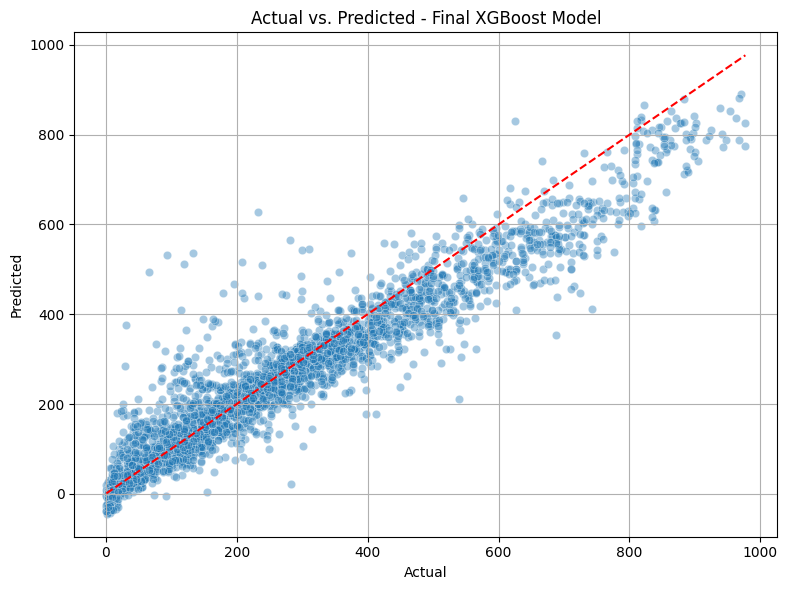

In [1983]:
# Predict on the test set
y_pred_final = final_model.predict(X_test)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted - Final XGBoost Model")
plt.grid(True)
plt.tight_layout()
plt.show()


Throughout this project, I followed a complete machine learning pipeline—from data exploration to model deployment—using a structured, iterative approach. I began with thorough EDA and feature engineering, transforming and encoding relevant features based on domain knowledge and statistical insight. I then trained and compared three models (Linear Regression, Random Forest, and XGBoost), tuning them using both randomized and Bayesian optimization. To further refine performance, I revisited earlier steps during an additional iteration, where I reanalyzed previously dropped features and applied Boruta for feature selection. While Boruta provided a fresh perspective, my original selections yielded stronger results. Ultimately, the tuned XGBoost model emerged as the best-performing option, achieving an R² of 0.91 on the test set. This process highlighted the value of both automated methods and human insight, and reinforced the importance of iterative evaluation in building reliable, generalizable models.